In [1]:
!pip install pmdarima==2.0.4 pingouin neuralprophet==0.9.0 plotly-resampler -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/

# Context

This project focuses on forecasting **daily energy consumption** using time series modeling techniques, with a specific emphasis on the **AEP region** from the PJM Interconnection dataset. PJM Interconnection LLC is a regional transmission organisation (RTO) in the United States, coordinating the movement of wholesale electricity across multiple states in the Eastern Interconnection grid. The dataset provides historical hourly energy consumption (in megawatts), which I aggregate to a **daily level** to align with my goal of estimating broader consumption trends rather than granular hourly variations.

The central aim of this work is to **anticipate future energy usage patterns** to support energy planning, load balancing, and infrastructure optimisation.

Rather than relying solely on traditional time series methods, this project explores the **complementary strengths of Prophet and Neural Prophet**, as well as **ensemble strategies like model stacking**. By comparing performance and diagnostics across these approaches, I aim to deliver a **robust, interpretable, and scalable** daily forecasting model.

---

### **Objectives**

- **Aggregate and prepare time series data**  
  Clean and transform hourly energy consumption data into a reliable daily format, accounting for missing values, seasonality, and structural changes in the data.

- **Build and compare forecasting models**  
  Use **Prophet** as primary modeling techniques, with extensions into **Neural Prophet**, and **stacked ensembles** to improve predictive performance and resilience to non-linear trends.

- **Evaluate and visualise forecasts**  
  Assess model accuracy using time-based validation, while also exploring visual diagnostics to interpret trends, seasonality, and anomaly patterns.

---

> You can find the dataset [here](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?select=AEP_hourly.csv).   
> [Prophet Documentation](https://facebook.github.io/prophet/docs/quick_start.html).   
> [Neural Prophet Documentation](https://neuralprophet.com/tutorials/).

# Importing Important Libraries

In [2]:
# data wrangling
import holidays
import pandas as pd
from sklearn.preprocessing import (LabelEncoder,
                    OneHotEncoder, StandardScaler)

# numerical analysis
import numpy as np
from scipy.stats import f_oneway
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# data vis
import seaborn as sns
import matplotlib.pyplot as plt
from prophet.plot import add_changepoints_to_plot

# model training
from prophet import Prophet
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from neuralprophet import NeuralProphet, set_log_level
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# model evaluation
from sklearn.metrics import (silhouette_score,
            mean_squared_error, mean_absolute_error)

# hyper-params optimisation
from sklearn.model_selection import RandomizedSearchCV

# handling warnings
import warnings
warnings.filterwarnings('ignore')

print('All done...')

All done...


In [3]:
aep_df = pd.read_csv('/kaggle/input/hourly-energy-consumption/AEP_hourly.csv')
aep_df.head()

Datetime   AEP_MW
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0
2  2004-12-31 03:00:00  12577.0
3  2004-12-31 04:00:00  12517.0
4  2004-12-31 05:00:00  12670.0

In [4]:
aep_df.describe().T

count          mean          std     min      25%      50%  \
AEP_MW  121273.0  15499.513717  2591.399065  9581.0  13630.0  15310.0   

            75%      max  
AEP_MW  17200.0  25695.0

In [5]:
aep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


# Initial Feature Engineering

In [6]:
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, np.nan, y_true))) * 100


def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / np.where(denominator == 0, np.nan, denominator)) * 100

In [7]:
aep_df['Datetime'] = pd.to_datetime(aep_df['Datetime'])

# geting dates ready for prophet
aep_df['ds'] = aep_df['Datetime'].dt.date
aep_df['ds'] = pd.to_datetime(aep_df['ds'])

#aggregating daily data
aep_df = aep_df.groupby('ds')['AEP_MW'].mean().reset_index()

# rest of date data extraction
aep_df['year'] = aep_df['ds'].dt.year
aep_df['month'] = aep_df['ds'].dt.month
aep_df['day'] = aep_df['ds'].dt.day
aep_df['season'] = aep_df['month'].apply(month_to_season)

aep_df.head()

ds        AEP_MW  year  month  day  season
0 2004-10-01  14284.521739  2004     10    1  Autumn
1 2004-10-02  12999.875000  2004     10    2  Autumn
2 2004-10-03  12227.083333  2004     10    3  Autumn
3 2004-10-04  14309.041667  2004     10    4  Autumn
4 2004-10-05  14439.708333  2004     10    5  Autumn

In [8]:
aep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5055 entries, 0 to 5054
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      5055 non-null   datetime64[ns]
 1   AEP_MW  5055 non-null   float64       
 2   year    5055 non-null   int32         
 3   month   5055 non-null   int32         
 4   day     5055 non-null   int32         
 5   season  5055 non-null   object        
dtypes: datetime64[ns](1), float64(1), int32(3), object(1)
memory usage: 177.8+ KB


# EDA

##  Checking for Missing Dates

In [9]:
month_days = {
    1: [31],  2: [28, 29],  3: [31],
    4: [30],
    5: [31],  6: [30],
    7: [31],  8: [31], 9: [30],
    10: [31],  11: [30],
    12: [31]}

month_days_names = {
    1: 'January',  2: 'February',  3: 'March',
    4: 'April',  5: 'May',  6: 'June',
    7: 'July',  8: 'August', 9: 'September',
    10: 'October', 11: 'November',  12: 'December'}


year_month_grouped = aep_df.groupby(['year', 'month'])['day'].count().reset_index().sort_values(['year', 'month'])

for year in year_month_grouped.year.unique():
    complete_months_for_month = 0
    year_data = year_month_grouped[year_month_grouped['year'] == year]
    
    if len(year_data) == 12:
        print(f'\n{year} is complete, with 12 months... Inspecting each month of data now.')
    else:
        covered_dates = [month_days_names.get(month) for month in year_data.month]
        print(f'\n** ISSUE: {year} is NOT complete. \nIt only covers the following months: {covered_dates} ... Now inspecting available months of data.')

    for df_month, df_month_days in zip(year_data['month'], year_data['day']):
        if df_month_days not in month_days[df_month]:
            print(f'** ISSUE: {month_days_names.get(df_month)} has incomplete data')
        else:
            complete_months_for_month += 1
    if complete_months_for_month == len(year_data):
        print('All complete.')


** ISSUE: 2004 is NOT complete. 
It only covers the following months: ['October', 'November', 'December'] ... Now inspecting available months of data.
All complete.

2005 is complete, with 12 months... Inspecting each month of data now.
All complete.

2006 is complete, with 12 months... Inspecting each month of data now.
All complete.

2007 is complete, with 12 months... Inspecting each month of data now.
All complete.

2008 is complete, with 12 months... Inspecting each month of data now.
All complete.

2009 is complete, with 12 months... Inspecting each month of data now.
All complete.

2010 is complete, with 12 months... Inspecting each month of data now.
All complete.

2011 is complete, with 12 months... Inspecting each month of data now.
All complete.

2012 is complete, with 12 months... Inspecting each month of data now.
All complete.

2013 is complete, with 12 months... Inspecting each month of data now.
All complete.

2014 is complete, with 12 months... Inspecting each month o

## Data Stationary Check

In [10]:
result = adfuller(aep_df['AEP_MW'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -7.487515670339063
p-value: 4.597183239476787e-11


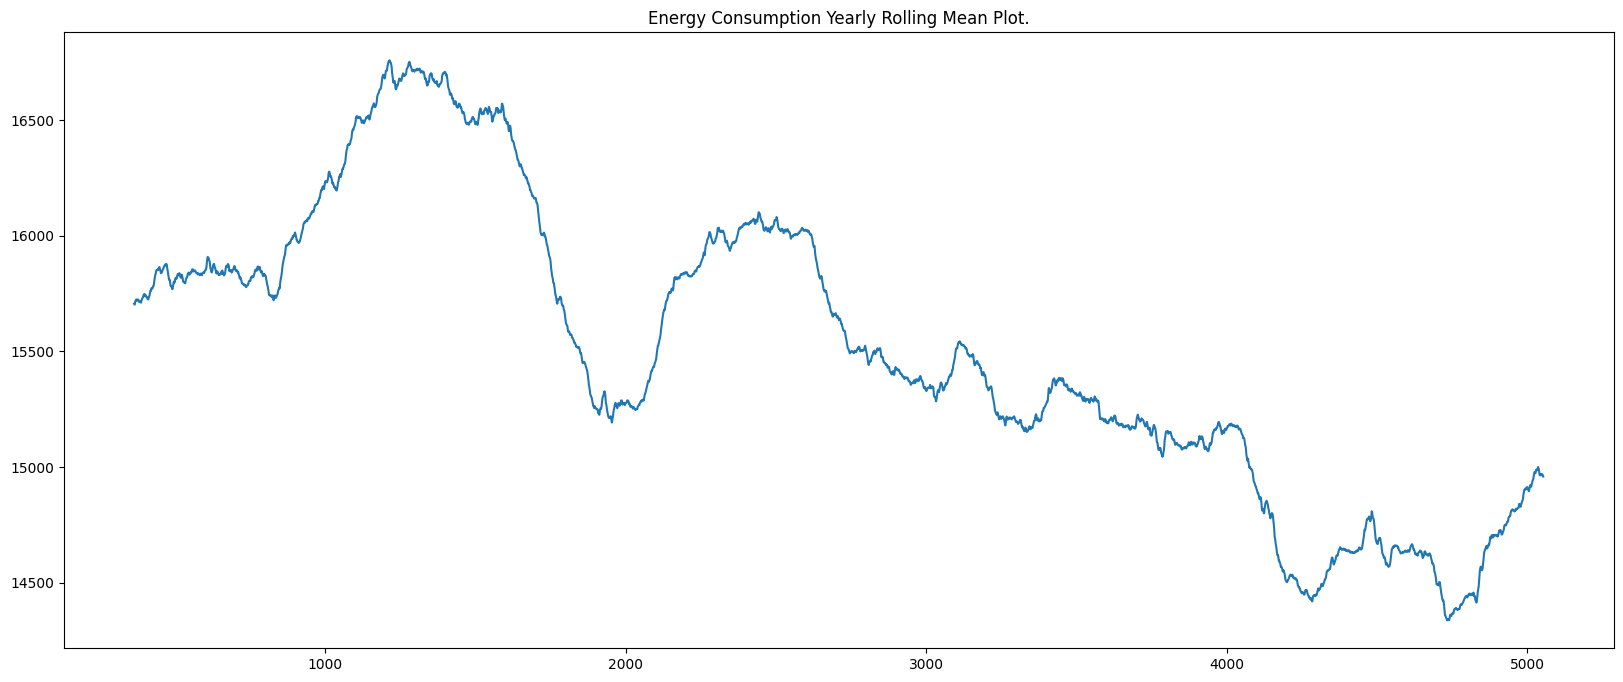

In [11]:
STANDARD_SIZE = (20, 8)
plt.figure(figsize = STANDARD_SIZE)
plt.title('Energy Consumption Yearly Rolling Mean Plot.')
aep_df['AEP_MW'].rolling(window = 365).mean().plot();

**Observation**

The *ADF* test suggests that the data `is stationary`. However, **the rolling mean plot suggests otherwise**.   

**Next**, I will be apply first order differencing and see the impact it has on the data in making it truly `stationary`.

**Subsequently**, I will experiment with ARIMA and Prophet, before eventually stacking models (calibration) for improved results where possible.

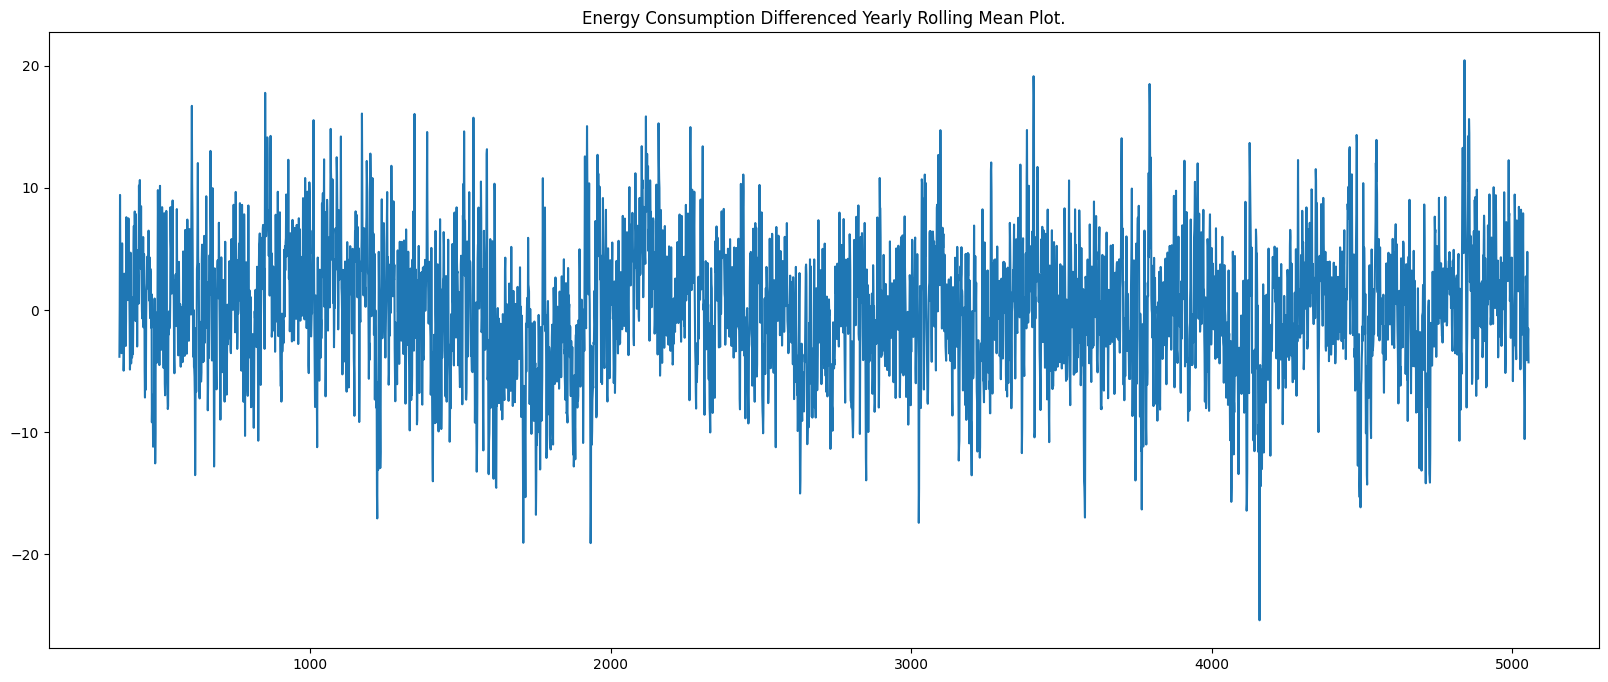

In [12]:
aep_df['AEP_MW_diff'] = aep_df['AEP_MW'].diff()

plt.figure(figsize = STANDARD_SIZE)
plt.title('Energy Consumption Differenced Yearly Rolling Mean Plot.')
aep_df['AEP_MW_diff'].rolling(window = 365).mean().plot();

aep_df.drop('AEP_MW_diff', axis = 1, inplace = True)

**Observation**

The differenced version is much more stable, with a mean around 0, and a roughly similar spread... When training my actual AR models, I'll likely be lag consumption levels by `1 - 10`.

## Other Visualisations

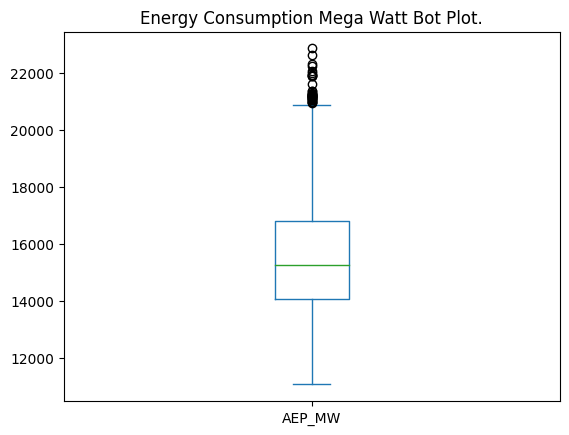

In [13]:
plt.title('Energy Consumption Mega Watt Bot Plot.')
aep_df['AEP_MW'].plot.box();

**Observation**

Some extreme usage values are observed... However, I will check if they occur randomly or in certain months/meaningful dates in order to determinf if they are truly outliers of reasonable.

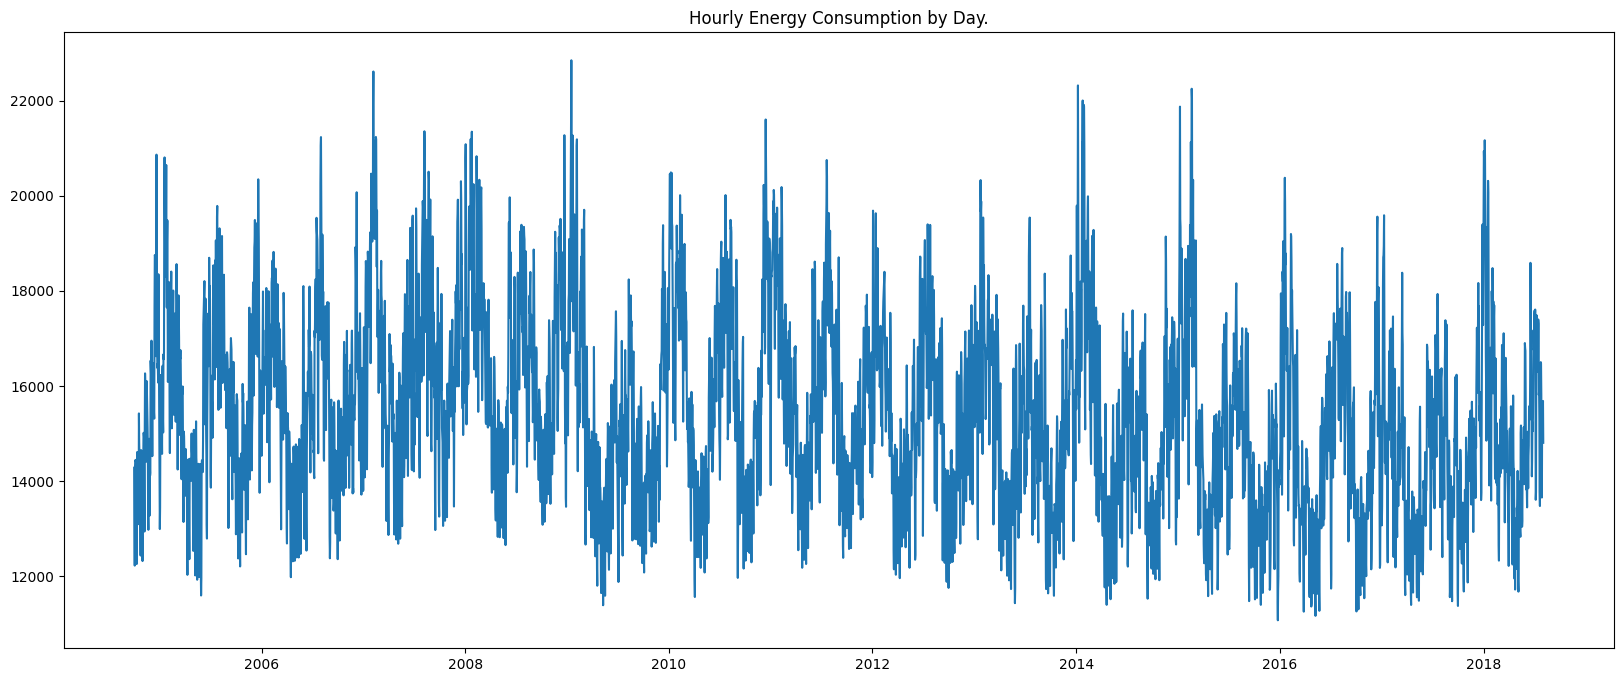

In [14]:
plt.figure(figsize = STANDARD_SIZE)
plt.plot(sorted(aep_df['ds']), (aep_df['AEP_MW']))
plt.title('Hourly Energy Consumption by Day.');

In [15]:
autumn = aep_df[aep_df['season'] == 'Autumn']['AEP_MW']
winter = aep_df[aep_df['season'] == 'Winter']['AEP_MW']
spring = aep_df[aep_df['season'] == 'Spring']['AEP_MW']
summer   = aep_df[aep_df['season'] == 'Summer']['AEP_MW']

f_stat, p_value = f_oneway(autumn, winter, spring, summer)
print(f'F-Stat: {f_stat}')
print(f'P-Value: {p_value}')

F-Stat: 740.9554097561941
P-Value: 0.0


**Observation**

The data has noticeable `seasonal trends` which by the p-value above are statistically significant.... Next, I will decompose and visualise the same info above **per season** of the year.

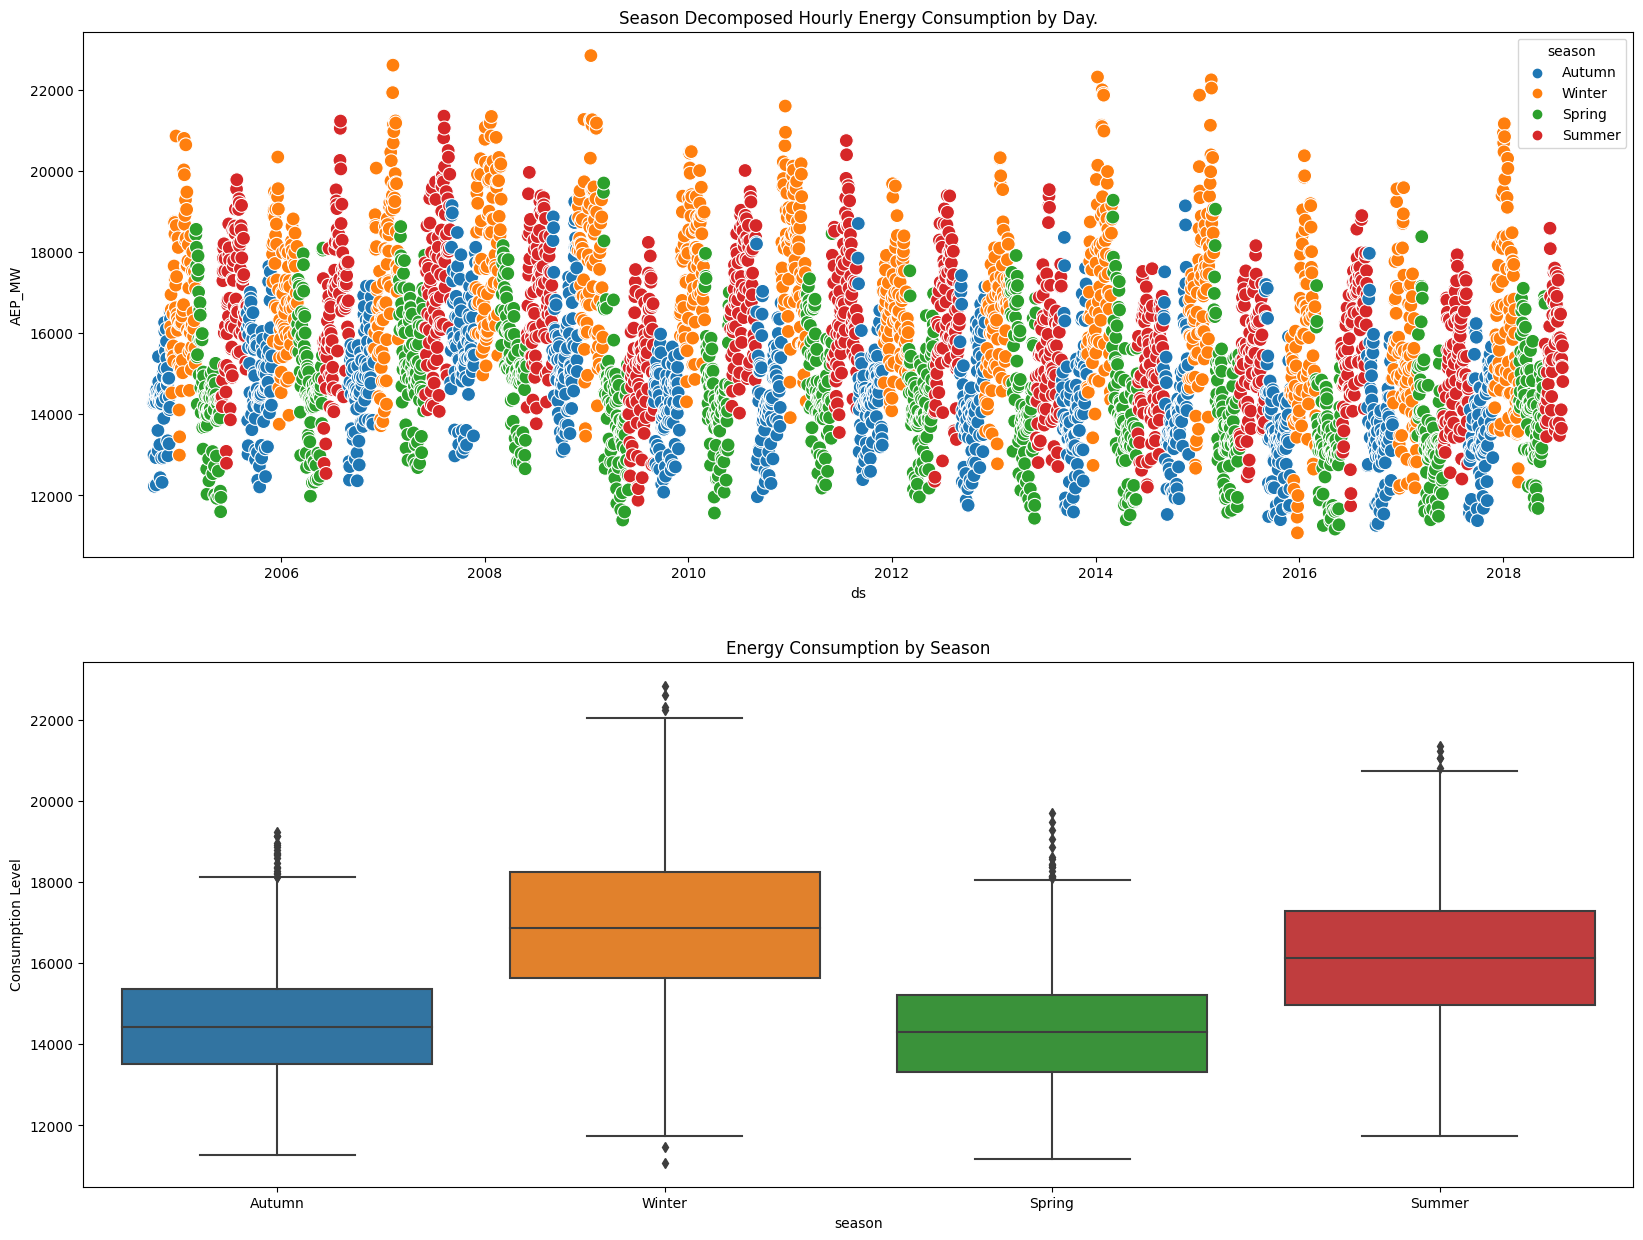

In [16]:
plt.figure(figsize = (20, 15))

aep_df_sorted = aep_df.sort_values('ds')

plt.subplot(2, 1, 1)
sns.scatterplot(
    data = aep_df_sorted, x = 'ds', y = 'AEP_MW',
    hue = 'season', palette = 'tab10', s = 100)
plt.title('Season Decomposed Hourly Energy Consumption by Day.')

plt.subplot(2, 1, 2)
sns.boxplot(x = 'season', y = 'AEP_MW', data = aep_df, order = ['Autumn', 'Winter', 'Spring', 'Summer'])
plt.title('Energy Consumption by Season')
plt.ylabel('Consumption Level');

**Observation**   

Consumption levels over the years are consistently highest during `Winter`, and `Summer` months, in that order.... While `Autumn`, and `Spring` are more on the moderate side.   

Plus, it kind of looks like there is a subtle downward trend as time goes on, but I can't say for sure... I'll let prophet reveal more information subsequently.

# Time Series Modelling

**Note** that I will train on all years, `except the last 2`. I will then test on the last year, and if the need be, I will calibrate with the second to the last year, then predict again on the last year.

## Data Splits

In [17]:
aep_df.rename(columns = {'AEP_MW' : 'y'}, inplace = True)

train = aep_df[aep_df['year'] <= aep_df['year'].max() - 2]

calib = aep_df[
    (aep_df['year'] > train['year'].max()) &
    (aep_df['year'] <= aep_df['year'].max() - 1)]

test = aep_df[aep_df['year'] == aep_df['year'].max()]


print(f'There are {len(train)} train samples. The first year is {train["year"].min()}, and the last is {train["year"].max()}')
print(f'There are {len(calib)} calibration samples. The first year is {calib["year"].min()}, and the last is {calib["year"].max()}')
print(f'There are {len(test)} test samples. The first year is {test["year"].min()}, and the last is {test["year"].max()}')

There are 4475 train samples. The first year is 2004, and the last is 2016
There are 365 calibration samples. The first year is 2017, and the last is 2017
There are 215 test samples. The first year is 2018, and the last is 2018


## PROPHET: Univariate Version

In [18]:
base_prophet_model = Prophet()
base_prophet_model.fit(train)

14:19:20 - cmdstanpy - INFO - Chain [1] start processing
14:19:21 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
test_period = len(calib) + len(test)

future = base_prophet_model.make_future_dataframe(periods = test_period)
forecast = base_prophet_model.predict(future)

In [20]:
forecast.head(5)

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2004-10-01  15454.028475  12561.519952  15583.289674  15454.028475   
1 2004-10-02  15454.915197  11368.965045  14373.628190  15454.915197   
2 2004-10-03  15455.801918  10911.504442  13880.828079  15455.801918   
3 2004-10-04  15456.688639  12390.375098  15538.581143  15456.688639   
4 2004-10-05  15457.575360  12813.607454  15736.258418  15457.575360   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  15454.028475    -1339.497032          -1339.497032          -1339.497032   
1  15454.915197    -2552.604015          -2552.604015          -2552.604015   
2  15455.801918    -3002.403981          -3002.403981          -3002.403981   
3  15456.688639    -1396.315125          -1396.315125          -1396.315125   
4  15457.575360    -1160.648723          -1160.648723          -1160.648723   

        weekly  weekly_lower  weekly_upper       yearly  yearly_lower  \
0   271.008008    271.008008    271.008008 -1610.505040  -1610.505040   
1  -906.902003   -906.902003   -906.902003 -1645.702012  -1645.702012   
2 -1322.319941  -1322.319941  -1322.319941 -1680.084040  -1680.084040   
3   316.841403    316.841403    316.841403 -1713.156528  -1713.156528   
4   583.699680    583.699680    583.699680 -1744.348403  -1744.348403   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0  -1610.505040                   0.0                         0.0   
1  -1645.702012                   0.0                         0.0   
2  -1680.084040                   0.0                         0.0   
3  -1713.156528                   0.0                         0.0   
4  -1744.348403                   0.0                         0.0   

   multiplicative_terms_upper          yhat  
0                         0.0  14114.531443  
1                         0.0  12902.311181  
2                         0.0  12453.397937  
3                         0.0  14060.373514  
4                         0.0  14296.926638

### Error Analysis

In [21]:
train_y_true = train['y'].values
calib_y_true = calib['y'].values
test_y_true = test['y'].values

train_y_hat = forecast['yhat'][:len(train_y_true)].values
calib_y_hat = forecast['yhat'][len(train_y_true):len(train_y_true) + len(calib_y_true)].values
test_y_hat = forecast['yhat'][-len(test_y_true):].values


train_smape = smape(train_y_true, train_y_hat)
train_mae = mean_absolute_error(train_y_true, train_y_hat)
train_mape = mean_absolute_percentage_error(train_y_true, train_y_hat)
train_rmse = mean_squared_error(train_y_true, train_y_hat, squared = False)

calib_smape = smape(calib_y_true, calib_y_hat)
calib_mae = mean_absolute_error(calib_y_true, calib_y_hat)
calib_mape = mean_absolute_percentage_error(calib_y_true, calib_y_hat)
calib_rmse = mean_squared_error(calib_y_true, calib_y_hat, squared = False)

test_smape = smape(test_y_true, test_y_hat)
test_mae = mean_absolute_error(test_y_true, test_y_hat)
test_mape = mean_absolute_percentage_error(test_y_true, test_y_hat)
test_rmse = mean_squared_error(test_y_true, test_y_hat, squared = False)

print('** PROPHET: Train Data Eval Metrics (Base) **')
print(f'Mean Value: {np.mean(train_y_true):.2f}\n')
print(f'MAE: {train_mae:.2f}')
print(f'RMSE: {train_rmse:.2f}')
print(f'MAPE: {train_mape:.2f}%')
print(f'SMAPE: {train_smape:.2f}%')

print('\n\n** PROPHET: Calibration Data Eval Metrics (Base) **')
print(f'Mean Value: {np.mean(calib_y_true):.2f}\n')
print(f'MAE: {calib_mae:.2f}')
print(f'RMSE: {calib_rmse:.2f}')
print(f'MAPE: {calib_mape:.2f}%')
print(f'SMAPE: {calib_smape:.2f}%')

print('\n\n** PROPHET: Test Data Eval Metrics (Base) **')
print(f'Mean Value: {np.mean(test_y_true):.2f}\n')
print(f'MAE: {test_mae:.2f}')
print(f'RMSE: {test_rmse:.2f}')
print(f'MAPE: {test_mape:.2f}%')
print(f'SMAPE: {test_smape:.2f}%')

** PROPHET: Train Data Eval Metrics (Base) **
Mean Value: 15592.10

MAE: 896.51
RMSE: 1171.24
MAPE: 5.68%
SMAPE: 5.65%


** PROPHET: Calibration Data Eval Metrics (Base) **
Mean Value: 14484.06

MAE: 1031.99
RMSE: 1361.07
MAPE: 7.00%
SMAPE: 6.96%


** PROPHET: Test Data Eval Metrics (Base) **
Mean Value: 15288.27

MAE: 1387.75
RMSE: 1776.26
MAPE: 8.78%
SMAPE: 9.11%


**Observation**   

Noticeable degradation in predictive accuracy for future dates further down (calib and test sets)... Overall, the MAPE's are really nice for a model with nothing but time information. Other external data like temperature and holidays may have great impact on models performance. Also, the `MAE` and `RMSE` are quite close for each data split, meaning the errors are quite uniformly spread.   

The calibration results aren't meant to be displayed however, I have displayed them at this time to paint a clearer picture of the progressive degradation in forcast accuracy.

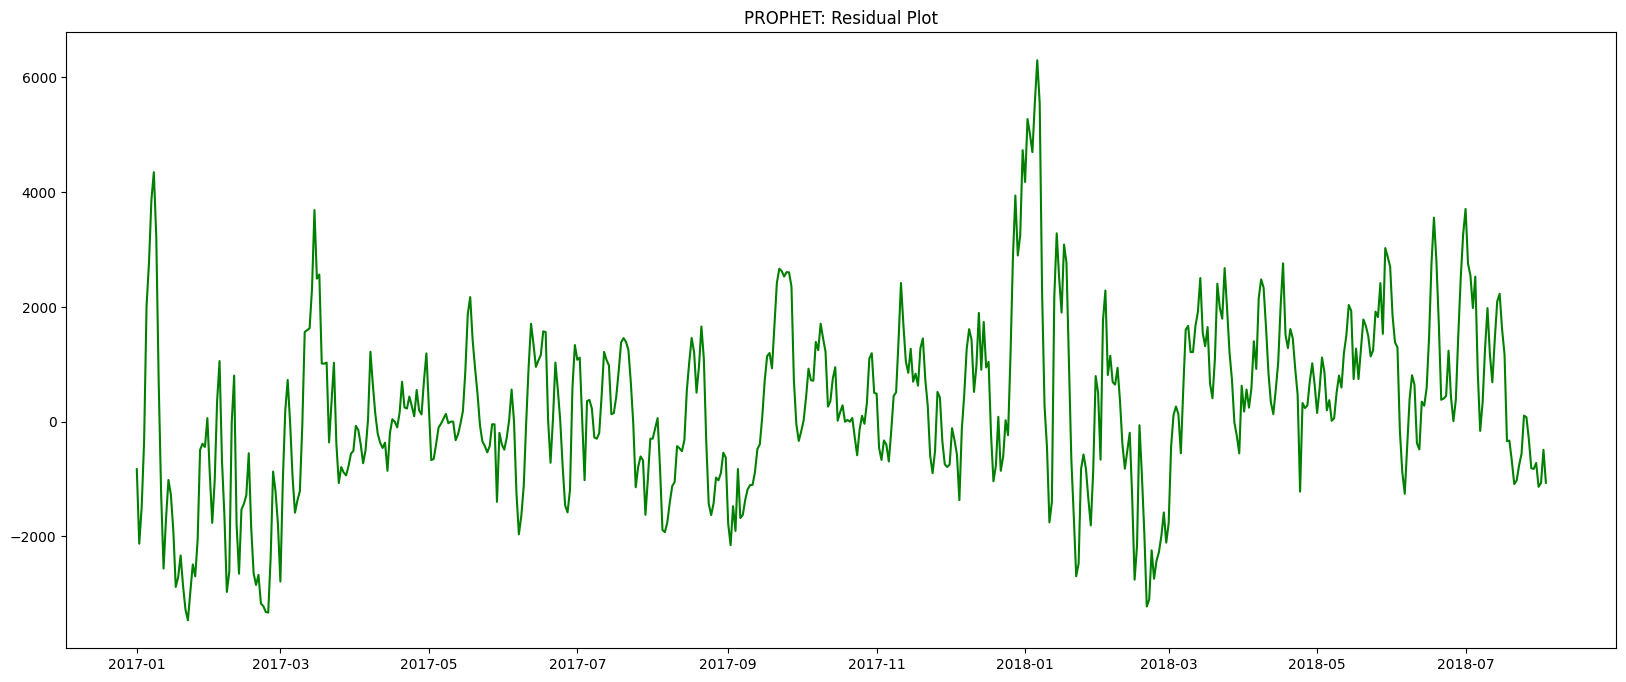

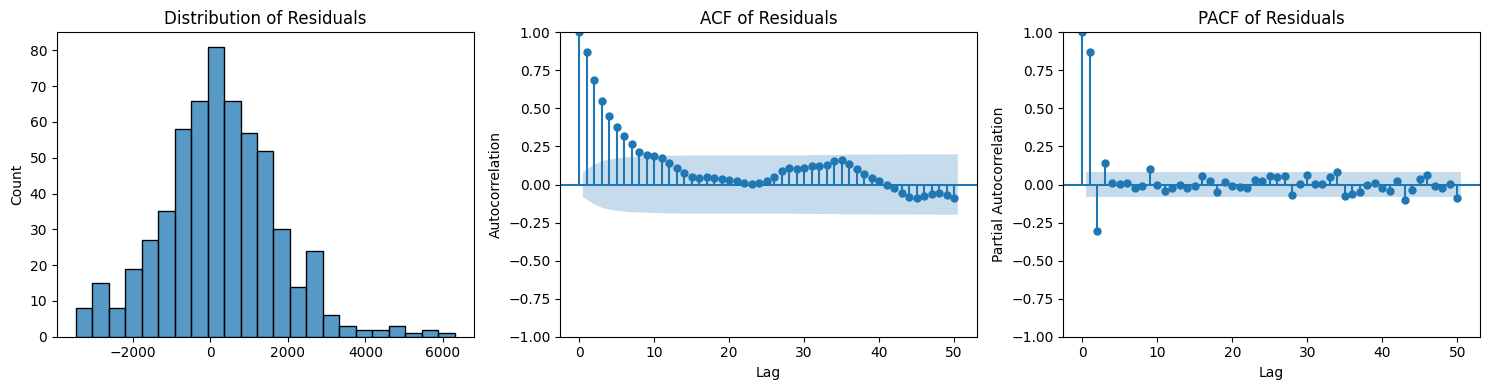

In [22]:
plt.figure(figsize = STANDARD_SIZE)

residuals = aep_df.iloc[len(train):, :2]['y'] - forecast['yhat'].iloc[len(train):]
plt.plot(forecast['ds'][len(train):], residuals, c = 'green')
plt.title('PROPHET: Residual Plot');


fig, axes = plt.subplots(1, 3, figsize = (15, 4))

sns.histplot(residuals, ax = axes[0])
plot_acf(residuals, ax = axes[1], lags = 50)
plot_pacf(residuals, ax = axes[2], lags = 50)

axes[0].set_title('Distribution of Residuals')

axes[1].set_title('ACF of Residuals')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')

axes[2].set_title('PACF of Residuals')
axes[2].set_xlabel('Lag')
axes[2].set_ylabel('Partial Autocorrelation')

plt.tight_layout();

**Observation**   

***The residual plot*** is quite interesting... There are definately some seasonal trends the model is failing to capture. Look at the most obvious repeated one being `January` period. Could be as a result of Christmas effect or maybe even snow. Once I start adding extra regressors, that residual error should hopefully drop drastically.  

The normal shaped residual histogram shows that the model has been able to capture the data's main pattern. `BUT` the **ACF** and **PCAF** plots show that the models errors are autocorellated, ***meaning that future errors can be predicted by regressing past error***.... That's bad, there's room for improvments.

### Forecasting

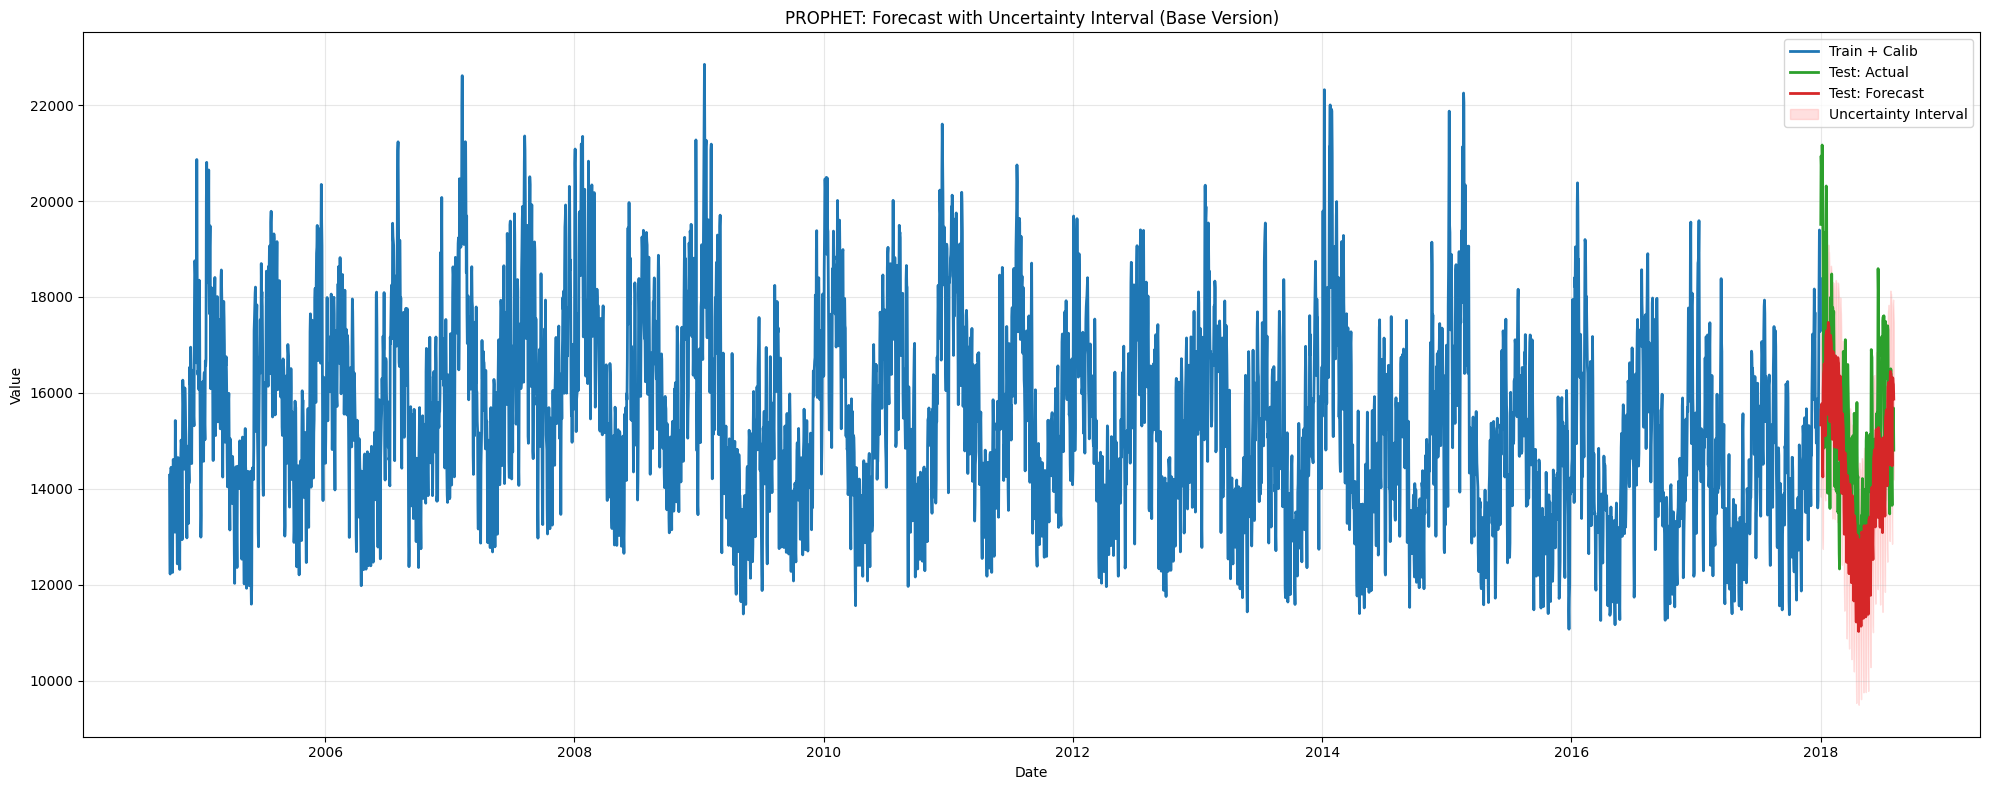

In [23]:
plt.figure(figsize = STANDARD_SIZE)

combined_actual = pd.concat([train[['ds', 'y']], calib[['ds', 'y']]], axis = 0)
calib_forecast = forecast[-(len(calib) + len(test)):-len(test)]
test_forecast = forecast[-len(test):]

plt.plot(combined_actual['ds'], combined_actual['y'], label = 'Train + Calib', color = '#1f77b4', linewidth = 2)
plt.plot(test['ds'], test['y'], label = 'Test: Actual', color = '#2ca02c', linewidth = 2)

plt.plot(test_forecast['ds'], test_forecast['yhat'], label = 'Test: Forecast', color = '#d62728', linewidth = 2)

plt.fill_between(test_forecast['ds'], test_forecast['yhat_lower'], test_forecast['yhat_upper'],
    color = '#ff9896', alpha = 0.3, label = 'Uncertainty Interval')

plt.title('PROPHET: Forecast with Uncertainty Interval (Base Version)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha = 0.3)
plt.tight_layout();

**Observation**   

This model captures the overall trend, and its uncertainty interval also contains majority of the true observation. There's room for improvments though.

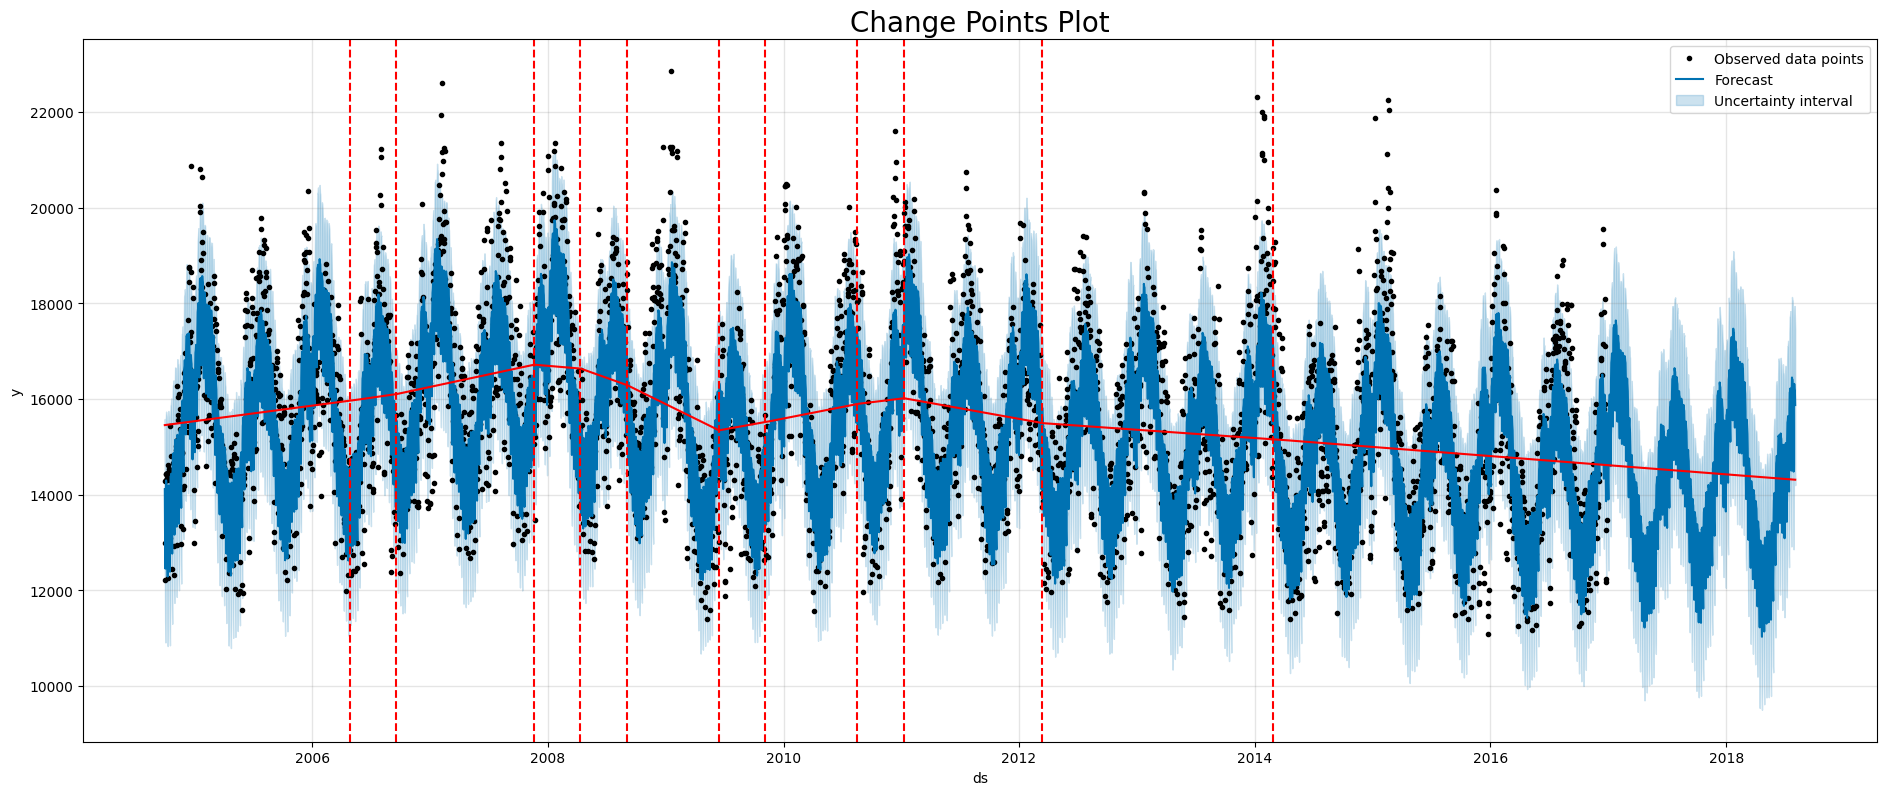

In [24]:
fig = base_prophet_model.plot(forecast)
fig.set_size_inches(*STANDARD_SIZE)
plt.title('Change Points Plot', fontsize = 20)
plt.legend()

a = add_changepoints_to_plot(fig.gca(), base_prophet_model, forecast)

*Observation*   

Therer's not alot of change points which is good to avoid overfitting... However; I might have to play around with that hyper-parameter a bit, just to squeese out as much as possible.

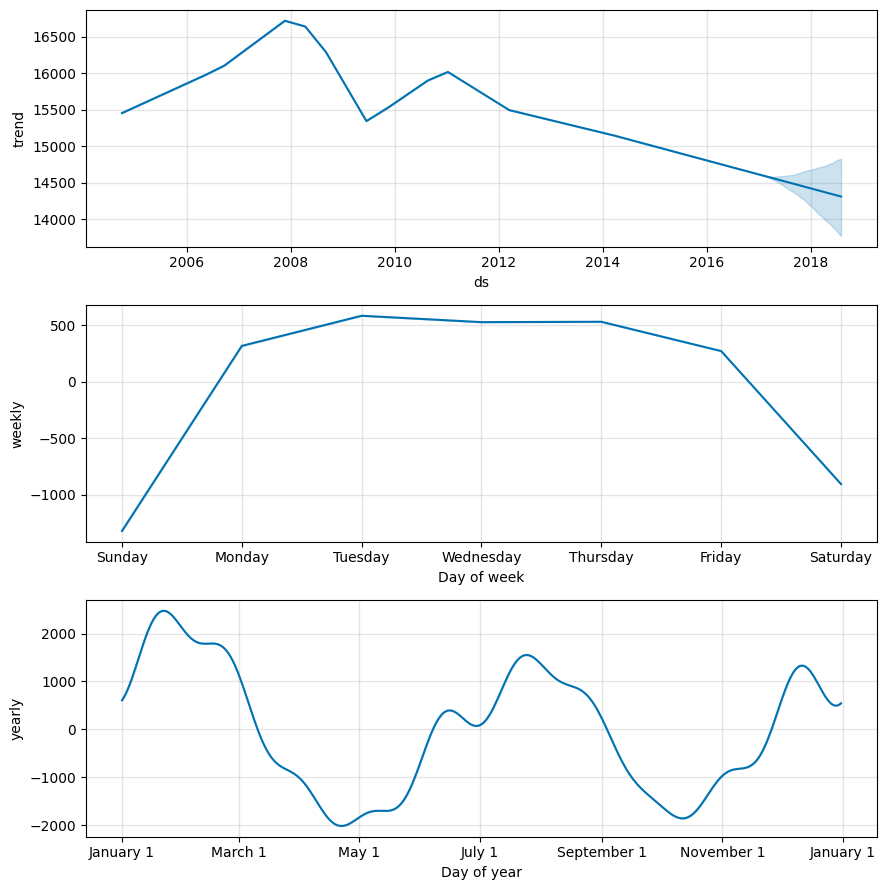

In [25]:
base_prophet_model.plot_components(forecast);

**Observation**   



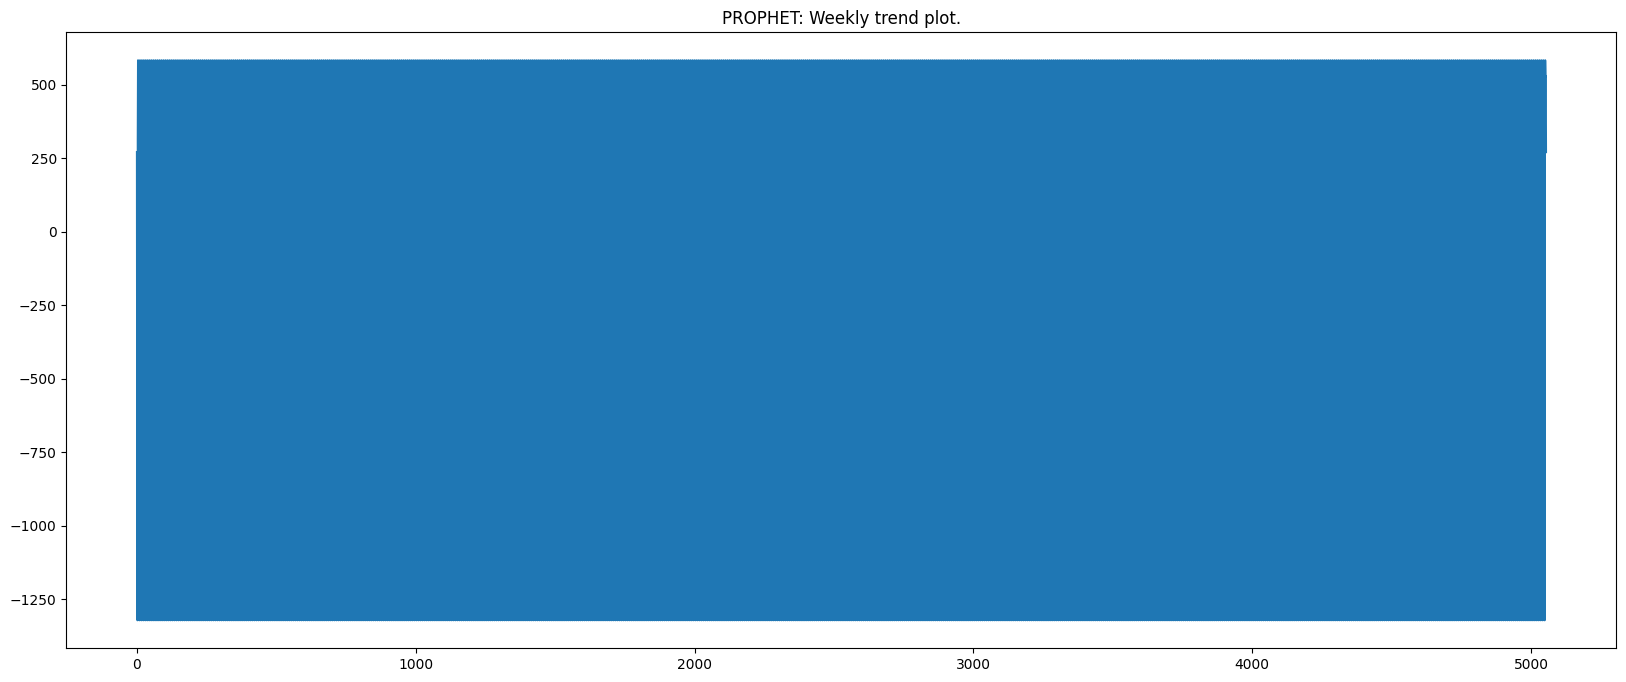

In [26]:
plt.figure(figsize = STANDARD_SIZE)
forecast['weekly'].plot()
plt.title('PROPHET: Weekly trend plot.');

**Observation**   

The trends in the data are not obvious over weeks... Wider periods like month, seasons, and year should better capture trends.

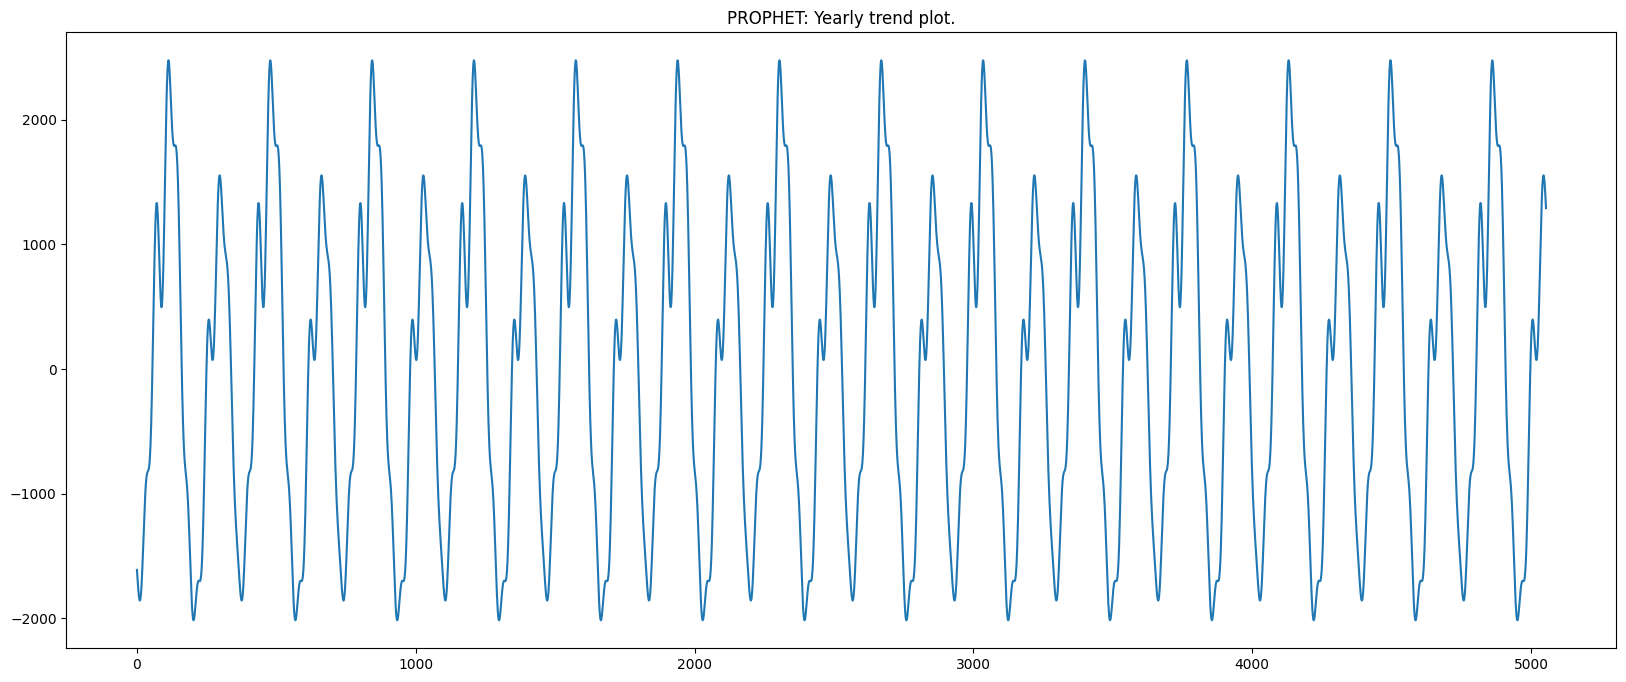

In [27]:
plt.figure(figsize = STANDARD_SIZE)
forecast['yearly'].plot()
plt.title('PROPHET: Yearly trend plot.');

**Observation**   

Clear observable yearly trends as expected.

## PROPHET: Multivariate + Optimised Version

In [28]:
# quick feature engineering

# seasons
seasons_ohe = OneHotEncoder(sparse_output = False, dtype = int, drop = 'first')
season_encoded = seasons_ohe.fit_transform(aep_df[['season']])

season_col_name = [f'season_{season.lower()}' for season in seasons_ohe.categories_[0][1:]]
for i, col_name in enumerate(season_col_name):
    aep_df[col_name] = season_encoded[:, i]


# holidays
us_holidays = holidays.US()
aep_df['holiday'] = aep_df.apply(lambda x: us_holidays.get(x['ds'], 'NA'), axis = 1)
print(f'\tNumber of different holidays in this dataset\n{aep_df["holiday"].value_counts()}')

holiday_df = aep_df[aep_df['holiday'] != 'NA'][['ds', 'holiday']].copy()
holiday_df['lower_window'] = 0
holiday_df['upper_window'] = 0
holiday_df.head()

	Number of different holidays in this dataset
holiday
NA                             4899
Columbus Day                     14
Veterans Day                     14
Thanksgiving Day                 14
Christmas Day                    14
New Year's Day                   14
Martin Luther King Jr. Day       14
Washington's Birthday            14
Memorial Day                     14
Independence Day                 14
Labor Day                        13
Christmas Day (observed)          5
New Year's Day (observed)         5
Veterans Day (observed)           4
Independence Day (observed)       3
Name: count, dtype: int64


ds                   holiday  lower_window  upper_window
10 2004-10-11              Columbus Day             0             0
41 2004-11-11              Veterans Day             0             0
55 2004-11-25          Thanksgiving Day             0             0
84 2004-12-24  Christmas Day (observed)             0             0
85 2004-12-25             Christmas Day             0             0

In [29]:
aep_df.head()

ds             y  year  month  day  season  season_spring  \
0 2004-10-01  14284.521739  2004     10    1  Autumn              0   
1 2004-10-02  12999.875000  2004     10    2  Autumn              0   
2 2004-10-03  12227.083333  2004     10    3  Autumn              0   
3 2004-10-04  14309.041667  2004     10    4  Autumn              0   
4 2004-10-05  14439.708333  2004     10    5  Autumn              0   

   season_summer  season_winter holiday  
0              0              0      NA  
1              0              0      NA  
2              0              0      NA  
3              0              0      NA  
4              0              0      NA

In [30]:
holiday_df.head()

ds                   holiday  lower_window  upper_window
10 2004-10-11              Columbus Day             0             0
41 2004-11-11              Veterans Day             0             0
55 2004-11-25          Thanksgiving Day             0             0
84 2004-12-24  Christmas Day (observed)             0             0
85 2004-12-25             Christmas Day             0             0

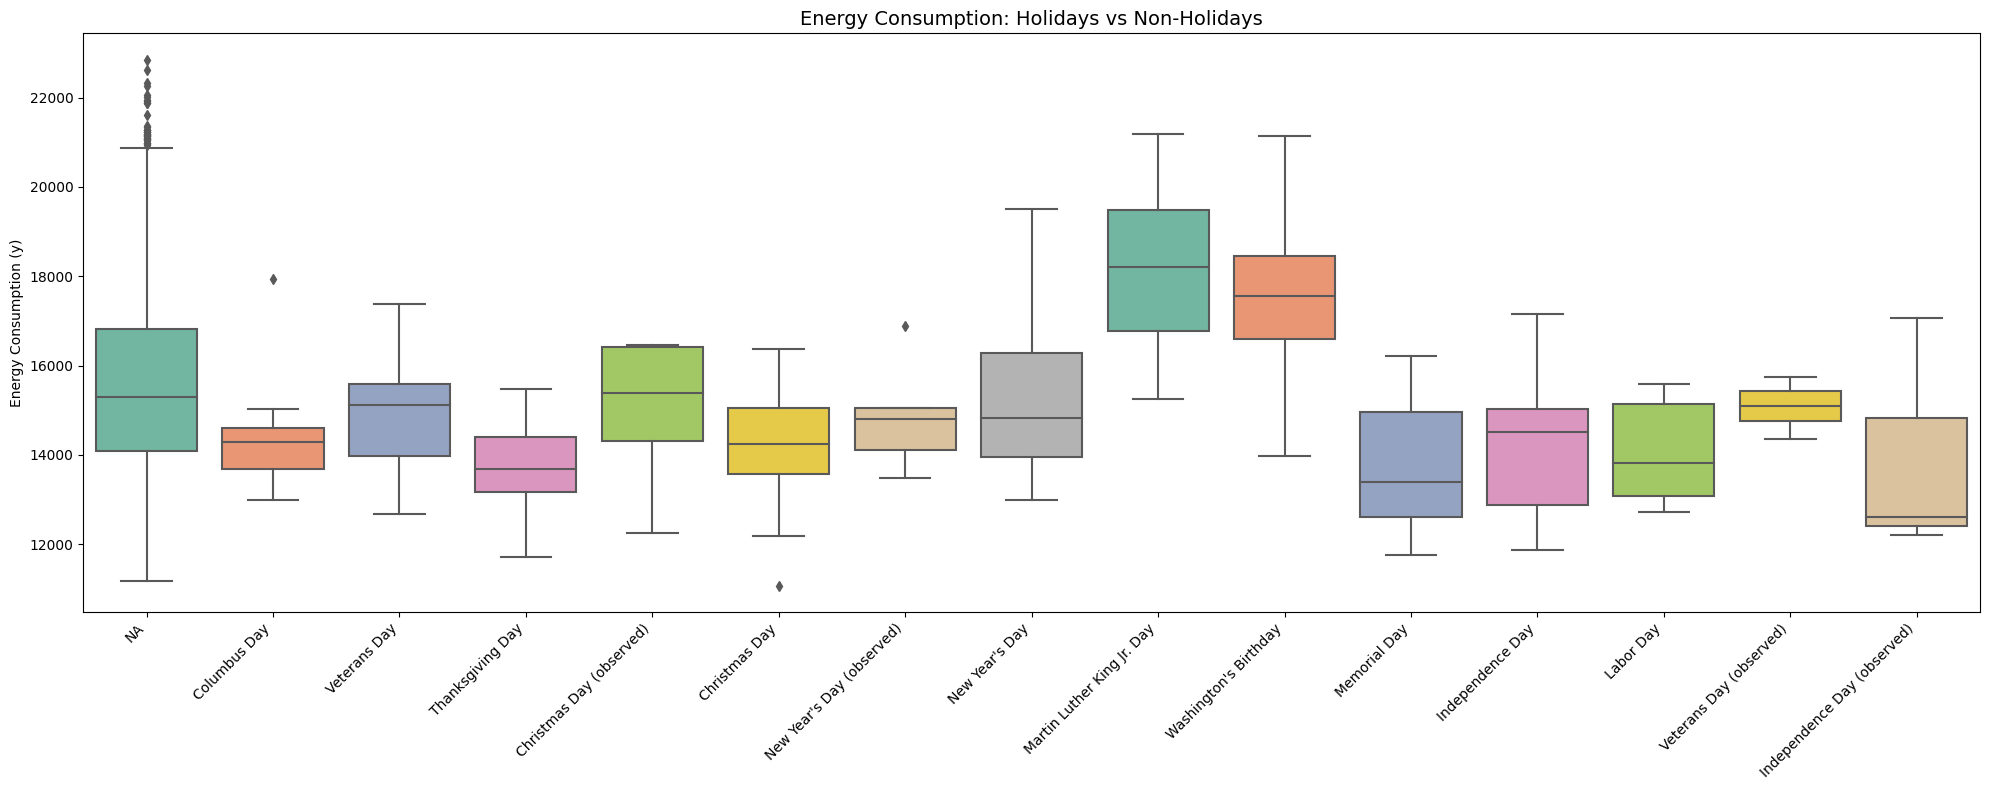

In [31]:
plt.figure(figsize = STANDARD_SIZE)

sns.boxplot(data = aep_df, x = 'holiday', y = 'y', palette = 'Set2')

plt.title('Energy Consumption: Holidays vs Non-Holidays', fontsize = 14)
plt.xlabel('')
plt.xticks(rotation = 45, ha = 'right')
plt.ylabel('Energy Consumption (y)')
plt.tight_layout();

**Observation**

The consumption levels by holidays show ***noticeable variance*** and ***outliers `(especially on days without holidays)`***. Those outliers may be errors or due to other confounding factors... weather maybe?. Holidays such as `Martin Luther King Jr. Day` and `Washington’s Birthday` show higher energy use, while some others like `Memorial Day`, `Labor Day`) seem to reduce consumption even when compared against non-holiday days. 

**Next**, I’ll include holiday effects to my prophet model, and have it learn these representations for itself.

In [32]:
train = aep_df[aep_df['year'] <= aep_df['year'].max() - 2]
train_set_holidays = holiday_df[
    (holiday_df['ds'] >= train['ds'].min()) &
    (holiday_df['ds'] <= train['ds'].max())]

calib = aep_df[
    (aep_df['year'] > train['year'].max()) &
    (aep_df['year'] <= aep_df['year'].max() - 1)]

calib_set_holidays = holiday_df[
    (holiday_df['ds'] >= calib['ds'].min()) &
    (holiday_df['ds'] <= calib['ds'].max())]

test = aep_df[aep_df['year'] == aep_df['year'].max()]
test_set_holidays = holiday_df[
    (holiday_df['ds'] >= test['ds'].min()) &
    (holiday_df['ds'] <= test['ds'].max())]


print(f'There are {len(train)} train samples, with {len(train_set_holidays)} holidays in the period between  {train["year"].min()}, and {train["year"].max()}.')
print(f'There are {len(calib)} calibration samples, with {len(calib_set_holidays)} holidays in the period between {calib["year"].min()}, and {calib["year"].max()}.')
print(f'There are {len(test)} test samples, with {len(test_set_holidays)} holidays in the period between {test["year"].min()}, and {test["year"].max()}.')

There are 4475 train samples, with 139 holidays in the period between  2004, and 2016.
There are 365 calibration samples, with 12 holidays in the period between 2017, and 2017.
There are 215 test samples, with 5 holidays in the period between 2018, and 2018.


In [33]:
optimised_prophet_model = Prophet(holidays = holiday_df,
                                  changepoint_prior_scale = 0.6,
                                  seasonality_prior_scale = 0.5,
                                  holidays_prior_scale = 15,
                                  seasonality_mode = 'multiplicative')

optimised_prophet_model.add_regressor('season_spring')
optimised_prophet_model.add_regressor('season_summer')
optimised_prophet_model.add_regressor('season_winter')

optimised_prophet_model.fit(train)

14:19:31 - cmdstanpy - INFO - Chain [1] start processing
14:19:34 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
future = optimised_prophet_model.make_future_dataframe(periods = test_period)

# including transformed season data.
future['season'] = future['ds'].dt.month.apply(month_to_season)
future_season_encoded = seasons_ohe.transform(future[['season']])

future_season_col_name = [f'season_{season.lower()}' for season in seasons_ohe.categories_[0][1:]]
for i, col_name in enumerate(future_season_col_name):
    future[col_name] = future_season_encoded[:, i]

optimised_forecast = optimised_prophet_model.predict(future)

In [35]:
optimised_forecast.head()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2004-10-01  14956.447454  12617.700764  15546.205428  14956.447454   
1 2004-10-02  14957.499283  11379.744905  14222.122972  14957.499283   
2 2004-10-03  14958.551113  10976.294204  13895.902333  14958.551113   
3 2004-10-04  14959.602942  12598.638427  15518.387347  14959.602942   
4 2004-10-05  14960.654772  12789.806060  15688.126702  14960.654772   

    trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0  14956.447454            0.0                  0.0                  0.0   
1  14957.499283            0.0                  0.0                  0.0   
2  14958.551113            0.0                  0.0                  0.0   
3  14959.602942            0.0                  0.0                  0.0   
4  14960.654772            0.0                  0.0                  0.0   

   Christmas Day (observed)  ...    weekly  weekly_lower  weekly_upper  \
0                       0.0  ...  0.017832      0.017832      0.017832   
1                       0.0  ... -0.061105     -0.061105     -0.061105   
2                       0.0  ... -0.088397     -0.088397     -0.088397   
3                       0.0  ...  0.024422      0.024422      0.024422   
4                       0.0  ...  0.037059      0.037059      0.037059   

     yearly  yearly_lower  yearly_upper  additive_terms  additive_terms_lower  \
0 -0.077598     -0.077598     -0.077598             0.0                   0.0   
1 -0.079568     -0.079568     -0.079568             0.0                   0.0   
2 -0.081466     -0.081466     -0.081466             0.0                   0.0   
3 -0.083276     -0.083276     -0.083276             0.0                   0.0   
4 -0.084975     -0.084975     -0.084975             0.0                   0.0   

   additive_terms_upper          yhat  
0                   0.0  14062.559222  
1                   0.0  12853.389589  
2                   0.0  12417.651086  
3                   0.0  14079.171004  
4                   0.0  14243.805048  

[5 rows x 76 columns]

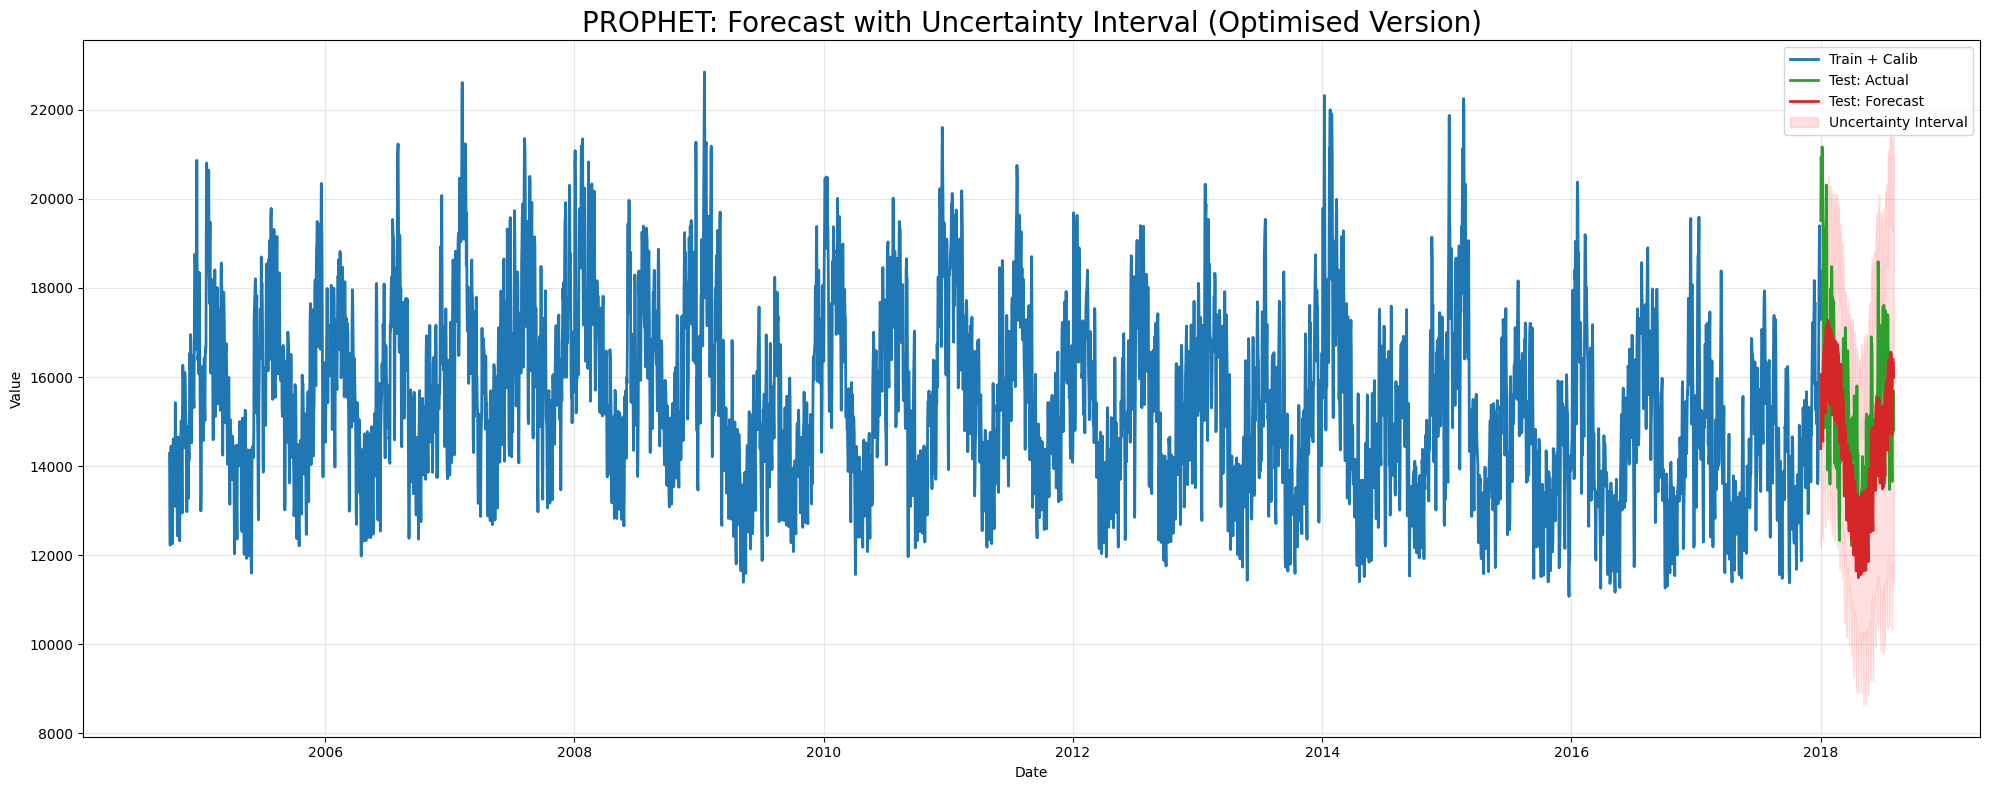

In [36]:
plt.figure(figsize = STANDARD_SIZE)

combined_actual = pd.concat([train[['ds', 'y']], calib[['ds', 'y']]], axis = 0)
calib_forecast = optimised_forecast[-(len(calib) + len(test)):-len(test)]
test_forecast = optimised_forecast[-len(test):]

plt.plot(combined_actual['ds'], combined_actual['y'], label = 'Train + Calib', color = '#1f77b4', linewidth = 2)
plt.plot(test['ds'], test['y'], label = 'Test: Actual', color = '#2ca02c', linewidth = 2)

plt.plot(test_forecast['ds'], test_forecast['yhat'], label = 'Test: Forecast', color = '#d62728', linewidth = 2)

plt.fill_between(test_forecast['ds'], test_forecast['yhat_lower'], test_forecast['yhat_upper'],
    color = '#ff9896', alpha = 0.3, label = 'Uncertainty Interval')

plt.title('PROPHET: Forecast with Uncertainty Interval (Optimised Version)', fontsize = 20)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha = 0.3)
plt.tight_layout();

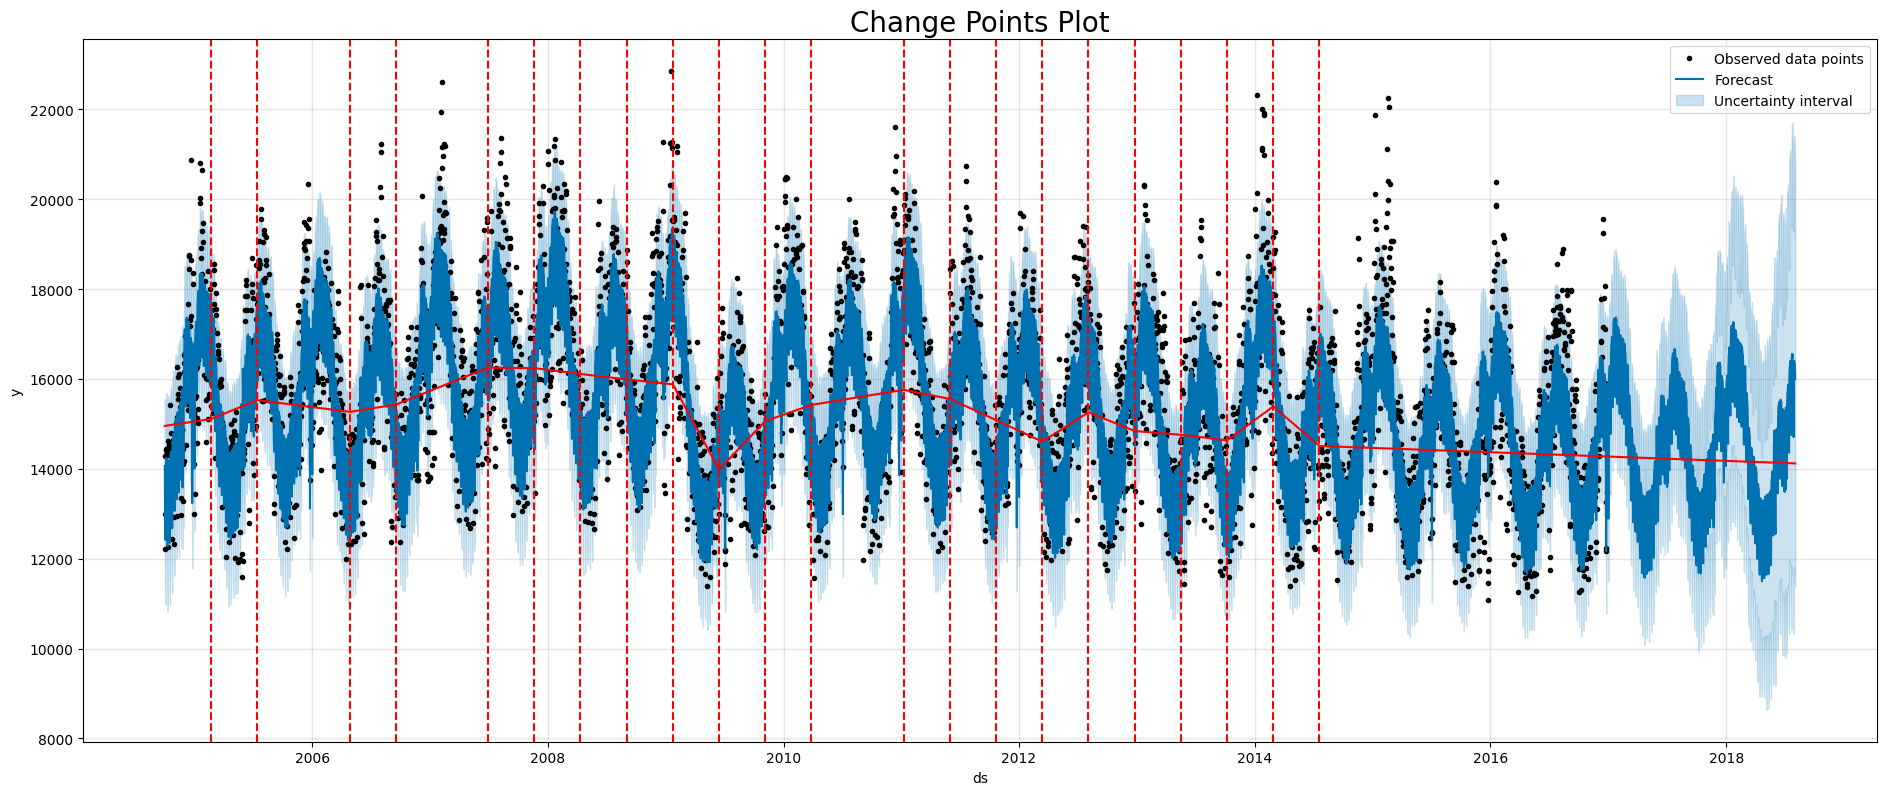

In [37]:
fig = optimised_prophet_model.plot(optimised_forecast)
fig.set_size_inches(*STANDARD_SIZE)
plt.title('Change Points Plot', fontsize = 20)
plt.legend()

a = add_changepoints_to_plot(fig.gca(), optimised_prophet_model, optimised_forecast)

### Error Analysis

In [38]:
engineered_train_y_true = train['y'].values
engineered_calib_y_true = calib['y'].values
engineered_test_y_true = test['y'].values

optimised_train_y_hat = optimised_forecast['yhat'][:len(engineered_train_y_true)].values
optimised_calib_y_hat = optimised_forecast['yhat'][len(engineered_train_y_true):len(engineered_train_y_true) + len(engineered_calib_y_true)].values
optimised_test_y_hat = optimised_forecast['yhat'][-len(engineered_test_y_true):].values

optimised_train_smape = smape(engineered_train_y_true, optimised_train_y_hat)
optimised_train_mae = mean_absolute_error(engineered_train_y_true, optimised_train_y_hat)
optimised_train_mape = mean_absolute_percentage_error(engineered_train_y_true, optimised_train_y_hat)
optimised_train_rmse = mean_squared_error(engineered_train_y_true, optimised_train_y_hat, squared = False)

# optimised_calib_smape = smape(engineered_calib_y_true, optimised_calib_y_hat)
# optimised_calib_mae = mean_absolute_error(engineered_calib_y_true, optimised_calib_y_hat)
# optimised_calib_mape = mean_absolute_percentage_error(engineered_calib_y_true, optimised_calib_y_hat)
# optimised_calib_rmse = mean_squared_error(engineered_calib_y_true, optimised_calib_y_hat, squared = False)

optimised_test_smape = smape(engineered_test_y_true, optimised_test_y_hat)
optimised_test_mae = mean_absolute_error(engineered_test_y_true, optimised_test_y_hat)
optimised_test_mape = mean_absolute_percentage_error(engineered_test_y_true, optimised_test_y_hat)
optimised_test_rmse = mean_squared_error(engineered_test_y_true, optimised_test_y_hat, squared = False)


print('** PROPHET: Train Data Eval Metrics (Optimised) **')
print(f'Mean Value: {np.mean(engineered_train_y_true):.2f}\n')
print(f'Optimised MAE: {optimised_train_mae:.2f}')
print(f'Optimised RMSE: {optimised_train_rmse:.2f}')
print(f'Optimised MAPE: {optimised_train_mape:.2f}%')
print(f'Optimised SMAPE: {optimised_train_smape:.2f}%')

# print('\n\n** PROPHET: Calibration Data Eval Metrics (Optimised) **')
# print(f'Mean Value: {np.mean(engineered_calib_y_true):.2f}\n')
# print(f'Optimised MAE: {optimised_calib_mae:.2f}')
# print(f'Optimised RMSE: {optimised_calib_rmse:.2f}')
# print(f'Optimised MAPE: {optimised_calib_mape:.2f}%')
# print(f'Optimised SMAPE: {optimised_calib_smape:.2f}%')

print('\n\n** PROPHET: Test Data Eval Metrics (Optimised) **')
print(f'Mean Value: {np.mean(engineered_test_y_true):.2f}\n')
print(f'Optimised MAE: {optimised_test_mae:.2f}')
print(f'Optimised RMSE: {optimised_test_rmse:.2f}')
print(f'Optimised MAPE: {optimised_test_mape:.2f}%')
print(f'Optimised SMAPE: {optimised_test_smape:.2f}%')

** PROPHET: Train Data Eval Metrics (Optimised) **
Mean Value: 15592.10

Optimised MAE: 855.79
Optimised RMSE: 1113.83
Optimised MAPE: 5.42%
Optimised SMAPE: 5.40%


** PROPHET: Test Data Eval Metrics (Optimised) **
Mean Value: 15288.27

Optimised MAE: 1252.11
Optimised RMSE: 1659.48
Optimised MAPE: 7.86%
Optimised SMAPE: 8.10%


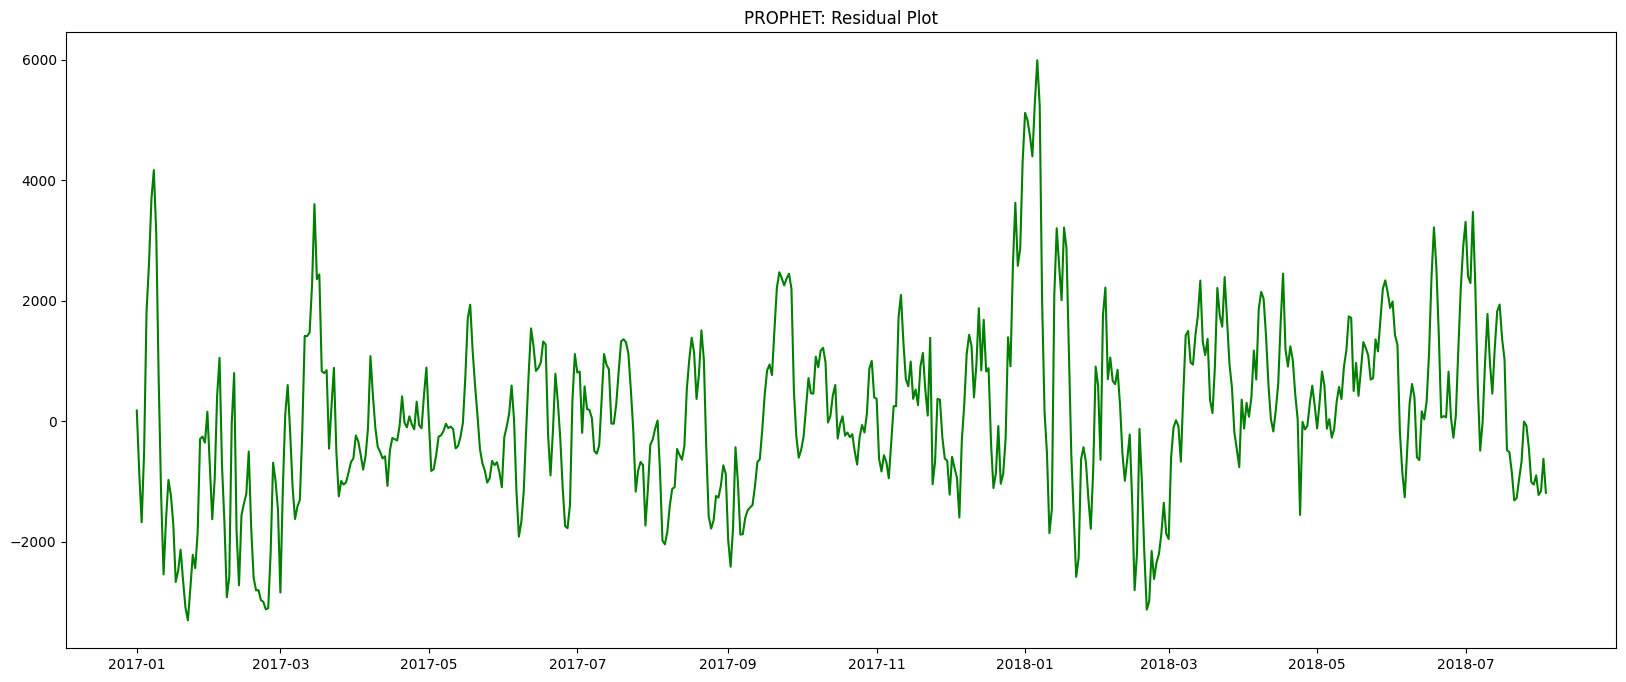

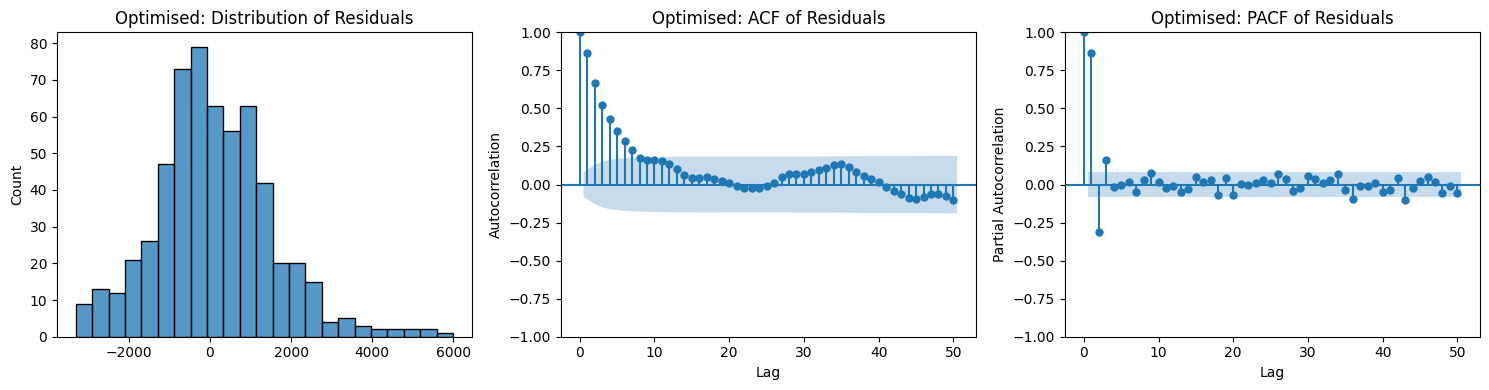

In [39]:
plt.figure(figsize = STANDARD_SIZE)

optimised_residuals = aep_df.iloc[len(train):, :2]['y'] - optimised_forecast['yhat'].iloc[len(train):]
plt.plot(optimised_forecast['ds'][len(train):], optimised_residuals, c = 'green')
plt.title('PROPHET: Residual Plot');


fig, axes = plt.subplots(1, 3, figsize = (15, 4))

sns.histplot(optimised_residuals, ax = axes[0])
plot_acf(optimised_residuals, ax = axes[1], lags = 50)
plot_pacf(optimised_residuals, ax = axes[2], lags = 50)

axes[0].set_title('Optimised: Distribution of Residuals')

axes[1].set_title('Optimised: ACF of Residuals')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')

axes[2].set_title('Optimised: PACF of Residuals')
axes[2].set_xlabel('Lag')
axes[2].set_ylabel('Partial Autocorrelation')

plt.tight_layout();

**Observation**   

All things considered, this version with optimised hyper-parameters performs much better than the base version, **especially** without drastically increasing the gap between train and test results.   

However, it is still unable to capture some trends, and the error is still autocorrelative... Next, I will try a model version where I can lag variables especially by 1 or 2, in order to try and combat this.   

One additional covariate I would have loved to experiment with is `Temperature`. However, this dataset cold be from either of *Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.*, and these regions generally have different weather consitions. Adding some generic average may do more harm than good.

## NEURAL PROPHET: Base

In [40]:
set_log_level('ERROR')

neural_prophet_model = NeuralProphet()
train_metrics = neural_prophet_model.fit(train.iloc[:, :2])

Training: |          | 0/? [00:00<?, ?it/s]

2025-06-23 14:19:42.872753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750688383.110576      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750688383.175772      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Finding best initial lr:   0%|          | 0/241 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [41]:
df_future = neural_prophet_model.make_future_dataframe(train.iloc[:, :2], n_historic_predictions = True, periods = test_period)
neural_prophet_forecast = neural_prophet_model.predict(df_future)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [42]:
neural_prophet_forecast.head()

ds             y         yhat1         trend  season_yearly  \
0 2004-10-01  14284.521739  14185.792969  15502.585938   -1598.635376   
1 2004-10-02  12999.875000  12984.982422  15503.435547   -1624.307251   
2 2004-10-03  12227.083333  12544.256836  15504.285156   -1647.678467   
3 2004-10-04  14309.041667  14141.867188  15505.134766   -1668.851685   
4 2004-10-05  14439.708333  14374.998047  15505.984375   -1687.770874   

   season_weekly  
0     281.842529  
1    -894.146423  
2   -1312.349854  
3     305.583710  
4     556.784302

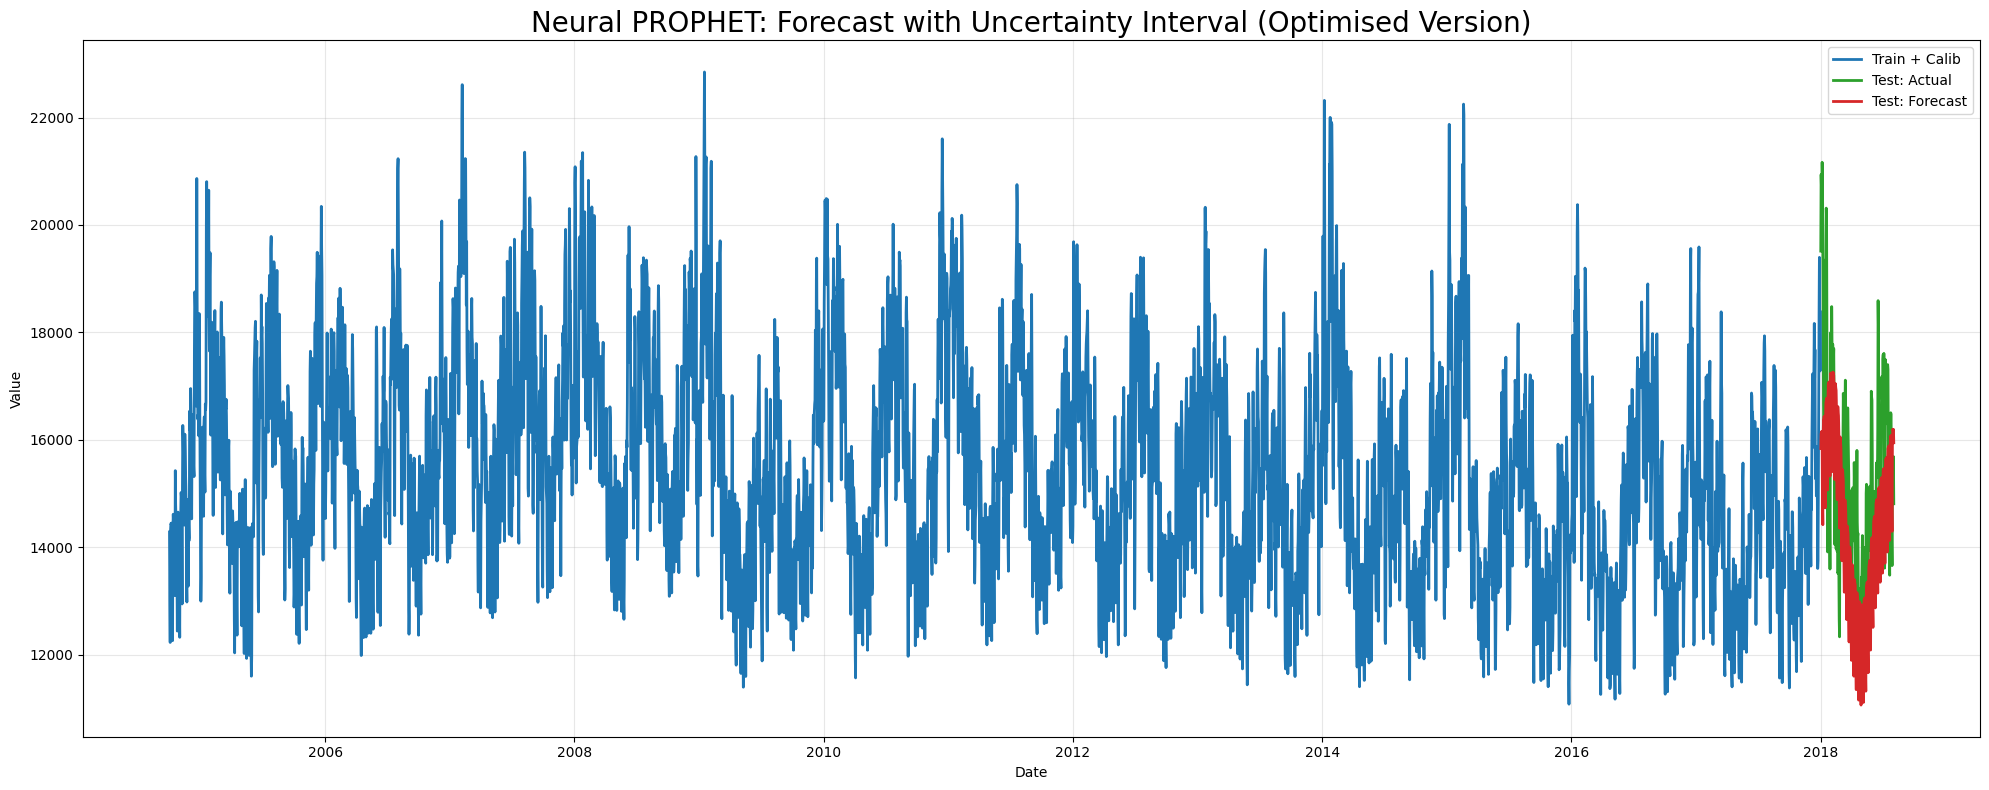

In [43]:
plt.figure(figsize = STANDARD_SIZE)

combined_actual = pd.concat([train[['ds', 'y']], calib[['ds', 'y']]], axis = 0)
calib_forecast = neural_prophet_forecast[-(len(calib) + len(test)):-len(test)]
test_forecast = neural_prophet_forecast[-len(test):]

plt.plot(combined_actual['ds'], combined_actual['y'], label = 'Train + Calib', color = '#1f77b4', linewidth = 2)
plt.plot(test['ds'], test['y'], label = 'Test: Actual', color = '#2ca02c', linewidth = 2)

plt.plot(test_forecast['ds'], test_forecast['yhat1'], label = 'Test: Forecast', color = '#d62728', linewidth = 2)

# plt.fill_between(test_forecast['ds'], test_forecast['yhat_lower'], test_forecast['yhat_upper'],
#     color = '#ff9896', alpha = 0.3, label = 'Uncertainty Interval')

plt.title('Neural PROPHET: Forecast with Uncertainty Interval (Optimised Version)', fontsize = 20)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha = 0.3)
plt.tight_layout();

### Error Analysis

In [44]:
engineered_train_y_true = train['y'].values
engineered_calib_y_true = calib['y'].values
engineered_test_y_true = test['y'].values

train_y_hat = neural_prophet_forecast['yhat1'][:len(engineered_train_y_true)].values
calib_y_hat = neural_prophet_forecast['yhat1'][len(engineered_train_y_true):len(engineered_train_y_true) + len(engineered_calib_y_true)].values
test_y_hat = neural_prophet_forecast['yhat1'][-len(engineered_test_y_true):].values

train_smape = smape(engineered_train_y_true, train_y_hat)
train_mae = mean_absolute_error(engineered_train_y_true, train_y_hat)
train_mape = mean_absolute_percentage_error(engineered_train_y_true, train_y_hat)
train_rmse = mean_squared_error(engineered_train_y_true, train_y_hat, squared = False)

# calib_smape = smape(engineered_calib_y_true, calib_y_hat)
# calib_mae = mean_absolute_error(engineered_calib_y_true, calib_y_hat)
# calib_mape = mean_absolute_percentage_error(engineered_calib_y_true, calib_y_hat)
# calib_rmse = mean_squared_error(engineered_calib_y_true, calib_y_hat, squared = False)

test_smape = smape(engineered_test_y_true, test_y_hat)
test_mae = mean_absolute_error(engineered_test_y_true, test_y_hat)
test_mape = mean_absolute_percentage_error(engineered_test_y_true, test_y_hat)
test_rmse = mean_squared_error(engineered_test_y_true, test_y_hat, squared = False)


print('** NEURAL PROPHET: Train Data Eval Metrics (Base) **')
print(f'Mean Value: {np.mean(engineered_train_y_true):.2f}\n')
print(f'MAE: {train_mae:.2f}')
print(f'RMSE: {train_rmse:.2f}')
print(f'MAPE: {train_mape:.2f}%')
print(f'SMAPE: {train_smape:.2f}%')

# print('\n\n** PROPHET: Calibration Data Eval Metrics (Optimised) **')
# print(f'Mean Value: {np.mean(engineered_calib_y_true):.2f}\n')
# print(f'Optimised MAE: {calib_mae:.2f}')
# print(f'Optimised RMSE: {calib_rmse:.2f}')
# print(f'Optimised MAPE: {calib_mape:.2f}%')
# print(f'Optimised SMAPE: {calib_smape:.2f}%')

print('\n\n** NEURAL PROPHET: Test Data Eval Metrics (Base) **')
print(f'Mean Value: {np.mean(engineered_test_y_true):.2f}\n')
print(f'MAE: {test_mae:.2f}')
print(f'RMSE: {test_rmse:.2f}')
print(f'MAPE: {test_mape:.2f}%')
print(f'SMAPE: {test_smape:.2f}%')

** NEURAL PROPHET: Train Data Eval Metrics (Base) **
Mean Value: 15592.10

MAE: 915.77
RMSE: 1199.18
MAPE: 5.80%
SMAPE: 5.77%


** NEURAL PROPHET: Test Data Eval Metrics (Base) **
Mean Value: 15288.27

MAE: 1320.58
RMSE: 1702.75
MAPE: 8.35%
SMAPE: 8.67%


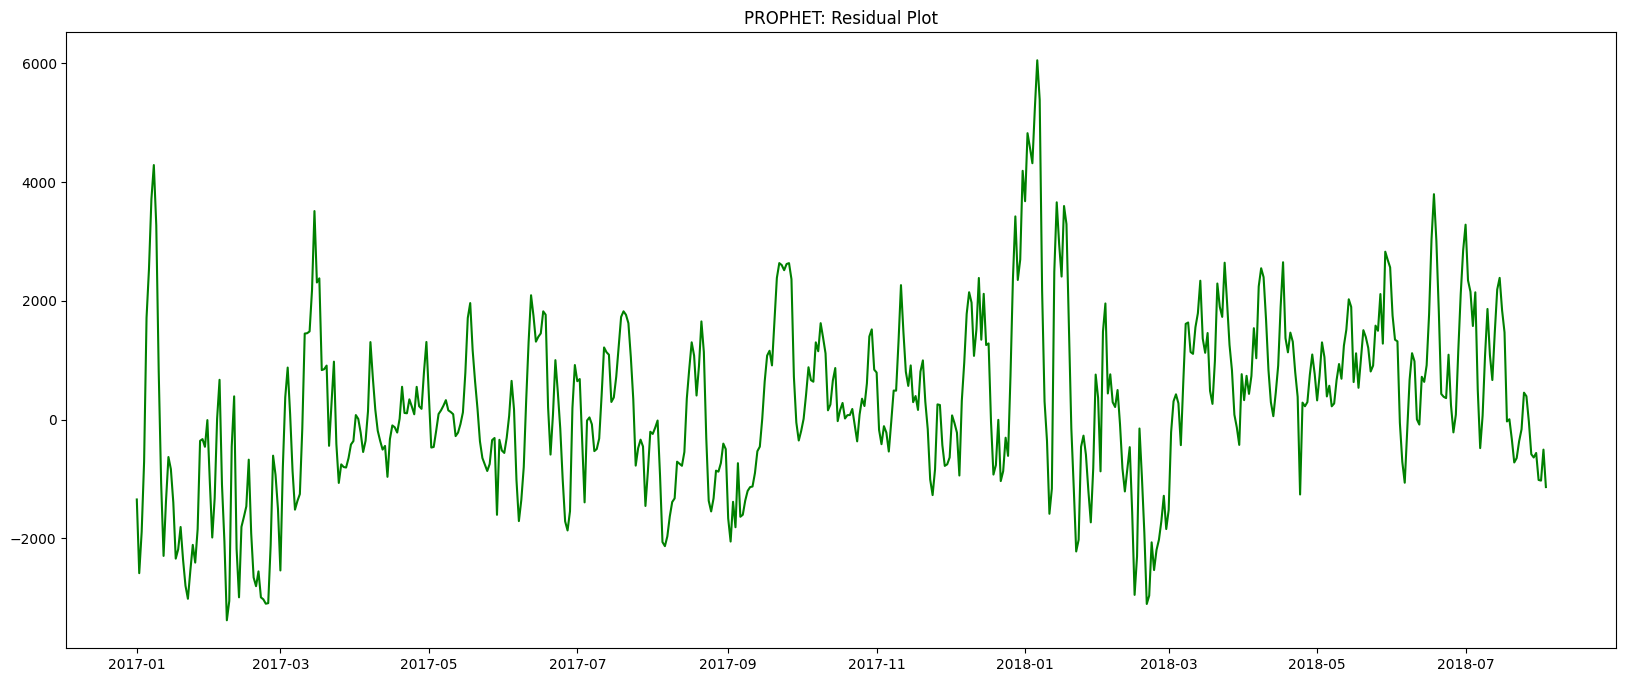

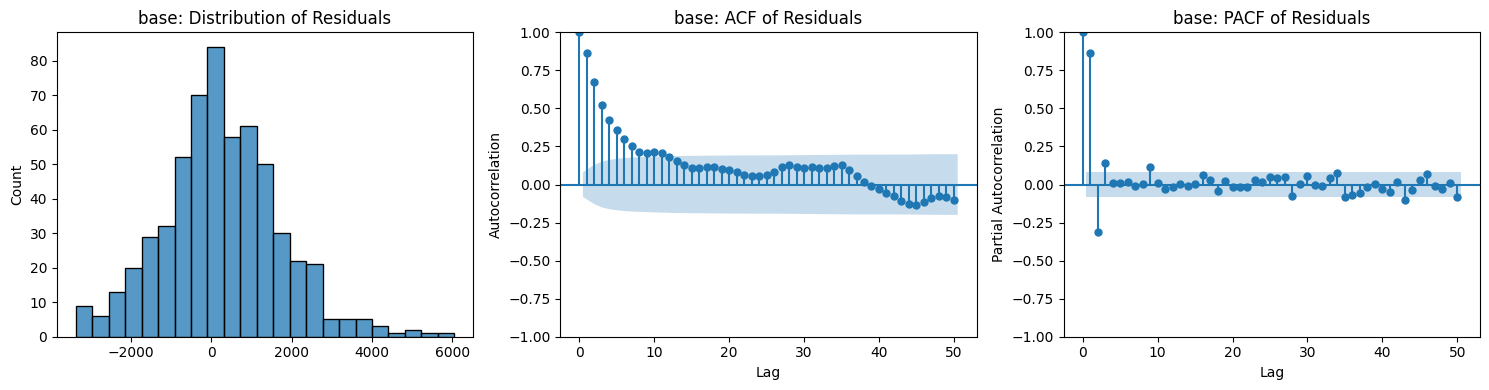

In [45]:
plt.figure(figsize = STANDARD_SIZE)

base_residuals = aep_df.iloc[len(train):, :2]['y'] - neural_prophet_forecast['yhat1'].iloc[len(train):]
plt.plot(neural_prophet_forecast['ds'][len(train):], base_residuals, c = 'green')
plt.title('PROPHET: Residual Plot');


fig, axes = plt.subplots(1, 3, figsize = (15, 4))

sns.histplot(base_residuals, ax = axes[0])
plot_acf(base_residuals, ax = axes[1], lags = 50)
plot_pacf(base_residuals, ax = axes[2], lags = 50)

axes[0].set_title('base: Distribution of Residuals')

axes[1].set_title('base: ACF of Residuals')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')

axes[2].set_title('base: PACF of Residuals')
axes[2].set_xlabel('Lag')
axes[2].set_ylabel('Partial Autocorrelation')

plt.tight_layout();

**Observation**   

Already, without any additional features or lagging, the base neural prophet model shows `better test performance` than the base Prophet model.

## NEURAL PROPHET: Optimised

In [46]:
n_lags = 10
optimised_neural_prophet_model = NeuralProphet(n_changepoints = 6, n_lags = n_lags)
optimised_train_metrics = optimised_neural_prophet_model.fit(train.iloc[:, :2])

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/241 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [47]:
optimised_neural_prophet_forecast = optimised_neural_prophet_model.predict(aep_df.iloc[:, :2])
optimised_neural_prophet_forecast.dropna(inplace = True)
optimised_neural_prophet_forecast.reset_index(drop = True, inplace = True)

engineered_train_y_true_aligned = train['y'].values[n_lags:]
engineered_calib_y_true_aligned = calib['y'].values
engineered_test_y_true_aligned = test['y'].values

optimised_train_y_hat = optimised_neural_prophet_forecast['yhat1'][:len(engineered_train_y_true_aligned)].values
optimised_calib_y_hat = optimised_neural_prophet_forecast['yhat1'][len(engineered_train_y_true_aligned):
                                                                  len(engineered_train_y_true_aligned) + len(engineered_calib_y_true_aligned)].values
optimised_test_y_hat = optimised_neural_prophet_forecast['yhat1'][-len(engineered_test_y_true_aligned):].values

Predicting: |          | 0/? [00:00<?, ?it/s]

In [48]:
optimised_neural_prophet_model.plot_parameters(components = ['autoregression'])

FigureWidgetResampler({
    'data': [{'marker': {'color': '#2d92ff'},
              'name': 'AR',
              'type': 'bar',
              'uid': '6e9173f3-51b1-4de0-9406-226721d76559',
              'x': array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1]),
              'xaxis': 'x',
              'y': array([0.04337985, 0.00519663, 0.0884041 , 0.04687463, 0.08006843, 0.08736032,
                          0.02917678, 0.1405533 , 0.16854475, 0.3104412 ], dtype=float32),
              'yaxis': 'y'}],
    'layout': {'autosize': True,
               'font': {'size': 10},
               'height': 210,
               'hovermode': 'x unified',
               'margin': {'b': 0, 'l': 0, 'pad': 0, 'r': 10, 't': 10},
               'showlegend': False,
               'template': '...',
               'title': {'font': {'size': 12}},
               'width': 700,
               'xaxis': {'anchor': 'y',
                         'domain': [0.0, 1.0],
                         'linewidth': 1.5,
        

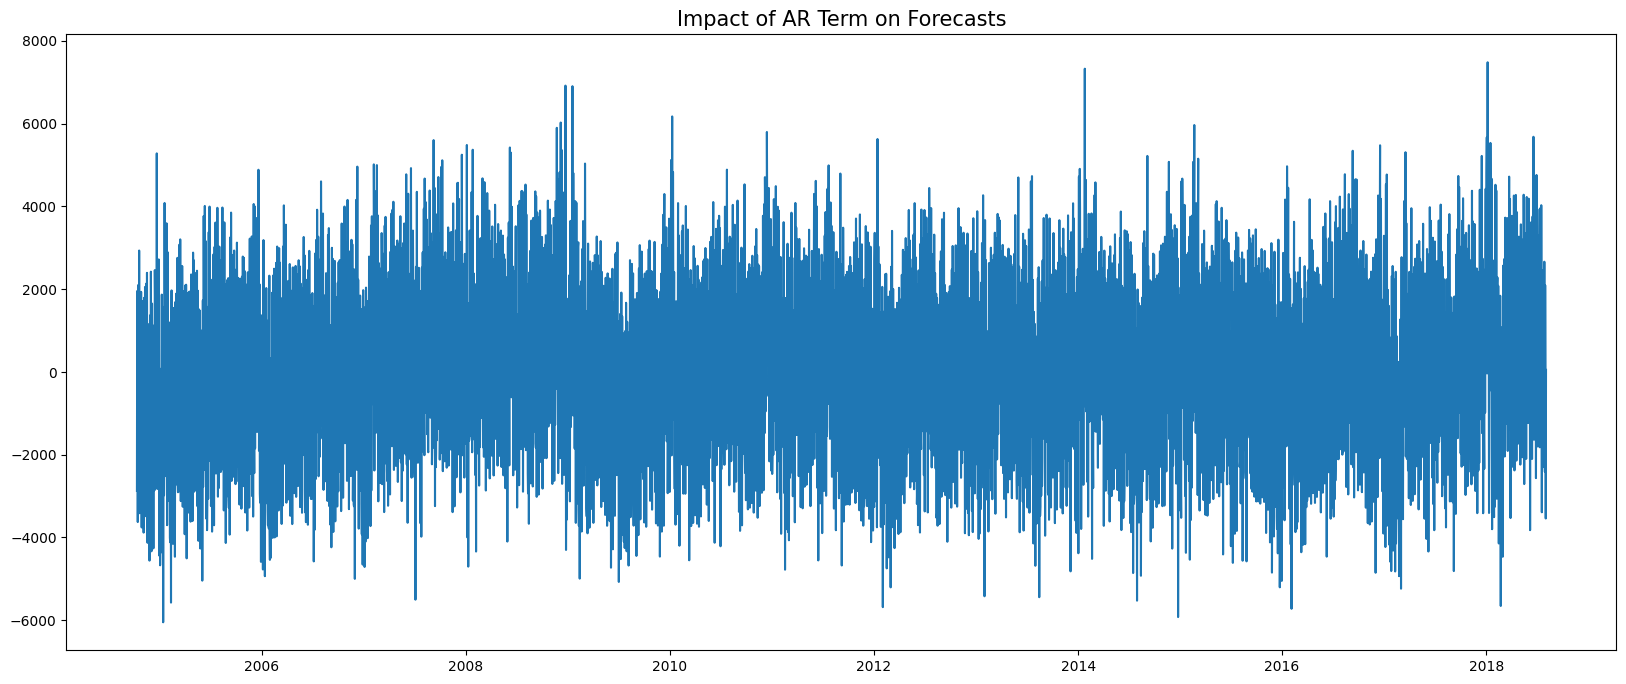

In [49]:
plt.figure(figsize = STANDARD_SIZE)
plt.title('Impact of AR Term on Forecasts', fontsize = 15)
plt.plot(optimised_neural_prophet_forecast['ds'], optimised_neural_prophet_forecast['ar1']);

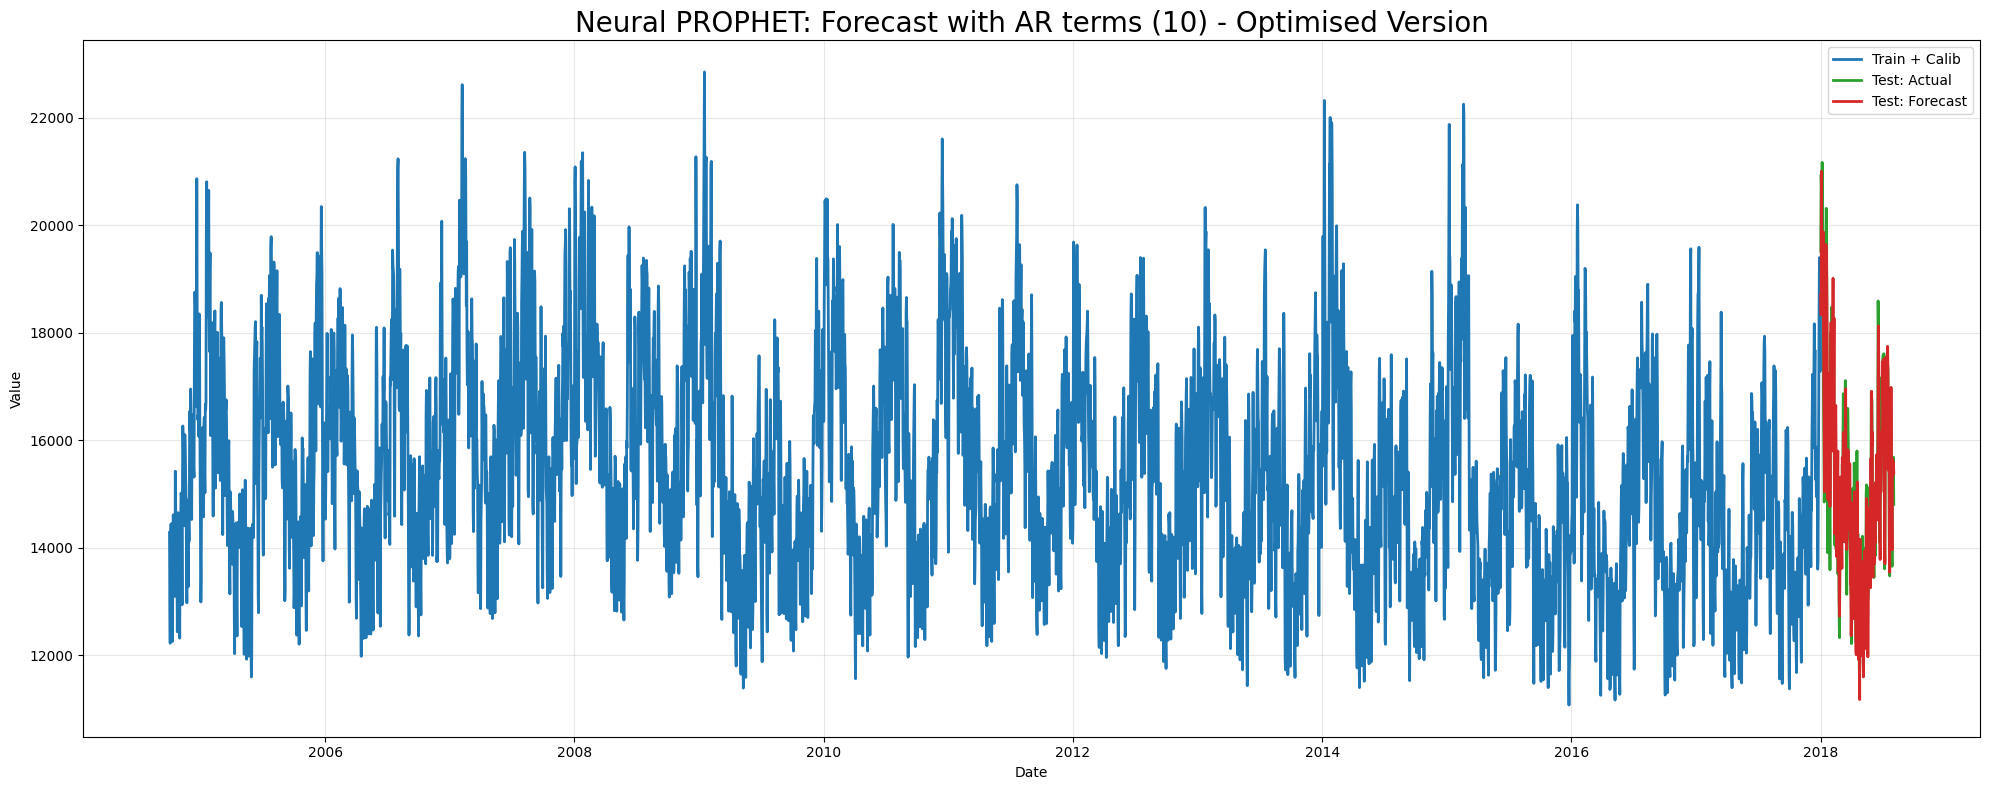

In [50]:
plt.figure(figsize = STANDARD_SIZE)

combined_actual = pd.concat([train[['ds', 'y']], calib[['ds', 'y']]], axis = 0)
optimised_neural_prophet_test_pred = optimised_neural_prophet_forecast.iloc[-len(engineered_test_y_true_aligned):]

plt.plot(combined_actual['ds'], combined_actual['y'], label = 'Train + Calib', color = '#1f77b4', linewidth = 2)
plt.plot(test['ds'], test['y'], label = 'Test: Actual', color = '#2ca02c', linewidth = 2)
plt.plot(optimised_neural_prophet_test_pred['ds'], optimised_neural_prophet_test_pred['yhat1'], label = 'Test: Forecast', color = '#d62728', linewidth = 2)

plt.title(f'Neural PROPHET: Forecast with AR terms ({n_lags}) - Optimised Version', fontsize = 20)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha = 0.3)
plt.tight_layout();

**Observation**   

Wow! That's really nice... The model predictions are the best they've ever been. I will now look into the details.

### Error Analysis

In [51]:
# metrics calculation on aligned data
optimised_train_smape = smape(engineered_train_y_true_aligned, optimised_train_y_hat)
optimised_train_mae = mean_absolute_error(engineered_train_y_true_aligned, optimised_train_y_hat)
optimised_train_mape = mean_absolute_percentage_error(engineered_train_y_true_aligned, optimised_train_y_hat)
optimised_train_rmse = mean_squared_error(engineered_train_y_true_aligned, optimised_train_y_hat, squared = False)

# optimised_calib_smape = smape(engineered_calib_y_true_aligned, optimised_calib_y_hat)
# optimised_calib_mae = mean_absolute_error(engineered_calib_y_true_aligned, optimised_calib_y_hat)
# optimised_calib_mape = mean_absolute_percentage_error(engineered_calib_y_true_aligned, optimised_calib_y_hat)
# optimised_calib_rmse = mean_squared_error(engineered_calib_y_true_aligned, optimised_calib_y_hat, squared = False)

optimised_test_smape = smape(engineered_test_y_true_aligned, optimised_test_y_hat)
optimised_test_mae = mean_absolute_error(engineered_test_y_true_aligned, optimised_test_y_hat)
optimised_test_mape = mean_absolute_percentage_error(engineered_test_y_true_aligned, optimised_test_y_hat)
optimised_test_rmse = mean_squared_error(engineered_test_y_true_aligned, optimised_test_y_hat, squared = False)

print('** OPTIMISED NEURAL PROPHET: Train Data Eval Metrics (Optimised) **')
print(f'Mean Value: {np.mean(engineered_train_y_true_aligned):.2f}\n')
print(f'Optimised MAE: {optimised_train_mae:.2f}')
print(f'Optimised RMSE: {optimised_train_rmse:.2f}')
print(f'Optimised MAPE: {optimised_train_mape:.2f}%')
print(f'Optimised SMAPE: {optimised_train_smape:.2f}%')

# print('\n\n** PROPHET: Calibration Data Eval Metrics (Optimised) **')
# print(f'Mean Value: {np.mean(engineered_calib_y_true_aligned):.2f}\n')
# print(f'Optimised MAE: {optimised_calib_mae:.2f}')
# print(f'Optimised RMSE: {optimised_calib_rmse:.2f}')
# print(f'Optimised MAPE: {optimised_calib_mape:.2f}%')
# print(f'Optimised SMAPE: {optimised_calib_smape:.2f}%')

print('\n\n** OPTIMISED NEURAL: Test Data Eval Metrics (Optimised) **')
print(f'Mean Value: {np.mean(engineered_test_y_true_aligned):.2f}\n')
print(f'Optimised MAE: {optimised_test_mae:.2f}')
print(f'Optimised RMSE: {optimised_test_rmse:.2f}')
print(f'Optimised MAPE: {optimised_test_mape:.2f}%')
print(f'Optimised SMAPE: {optimised_test_smape:.2f}%')

** OPTIMISED NEURAL PROPHET: Train Data Eval Metrics (Optimised) **
Mean Value: 15596.41

Optimised MAE: 555.07
Optimised RMSE: 751.33
Optimised MAPE: 3.52%
Optimised SMAPE: 3.51%


** OPTIMISED NEURAL: Test Data Eval Metrics (Optimised) **
Mean Value: 15288.27

Optimised MAE: 651.22
Optimised RMSE: 837.05
Optimised MAPE: 4.20%
Optimised SMAPE: 4.22%


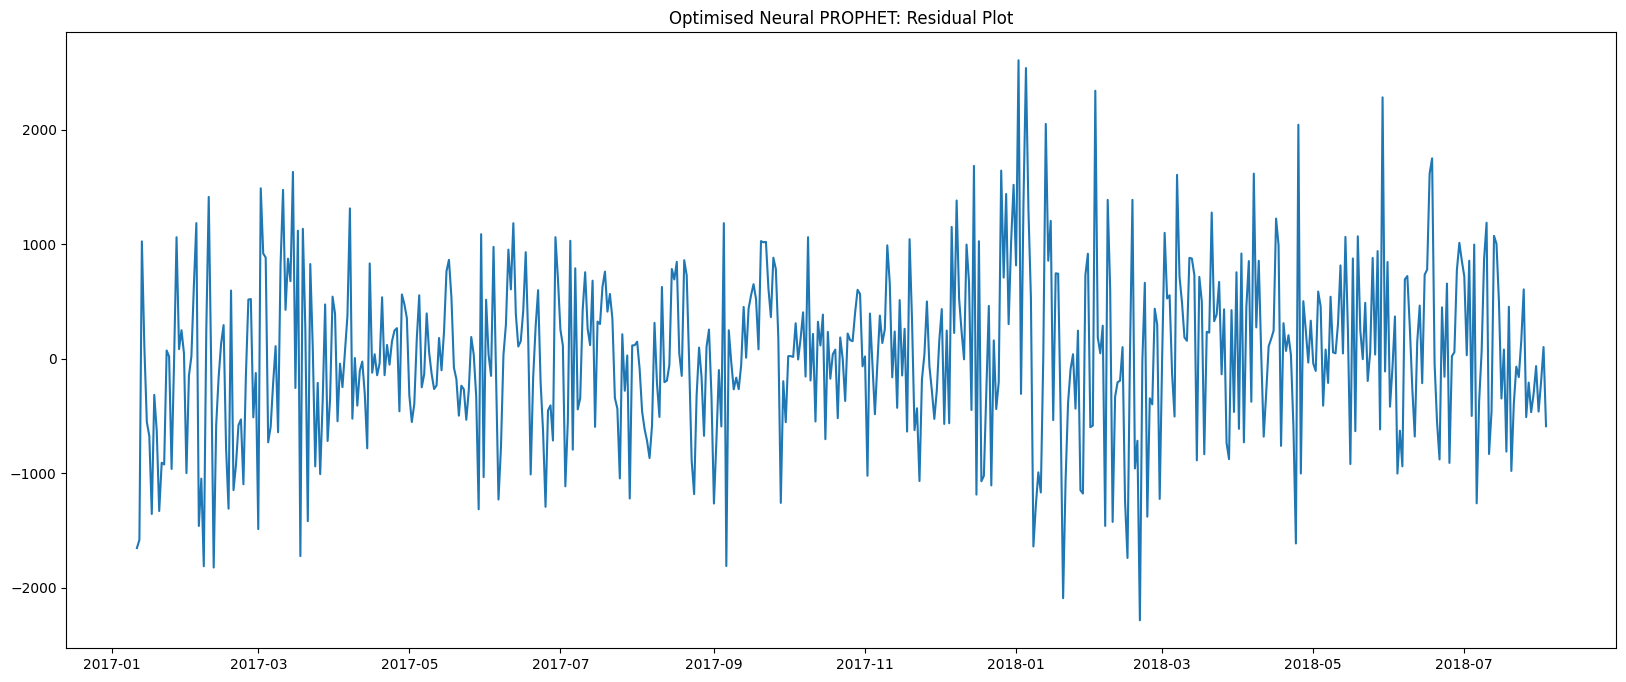

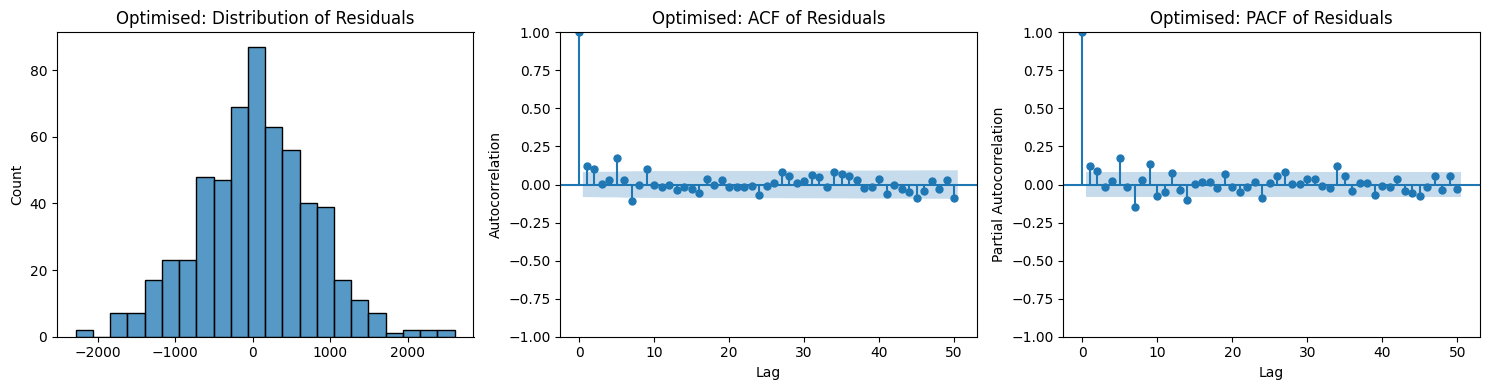

In [52]:
plt.figure(figsize = STANDARD_SIZE)

start_idx = len(train)

# account for n_lags offset in true values (drop first n_lags from train part of aep_df)
true_vals = aep_df['y'].iloc[start_idx + n_lags:].values

# aligning predictions to start from the same index
pred_vals = optimised_neural_prophet_forecast['yhat1'].iloc[start_idx:].values

base_residuals = true_vals - pred_vals
plt.plot(optimised_neural_prophet_forecast['ds'].iloc[start_idx:], base_residuals)
plt.title('Optimised Neural PROPHET: Residual Plot');

fig, axes = plt.subplots(1, 3, figsize = (15, 4))

sns.histplot(base_residuals, ax = axes[0])
plot_acf(base_residuals, ax = axes[1], lags = 50)
plot_pacf(base_residuals, ax = axes[2], lags = 50)

axes[0].set_title('Optimised: Distribution of Residuals')

axes[1].set_title('Optimised: ACF of Residuals')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Autocorrelation')

axes[2].set_title('Optimised: PACF of Residuals')
axes[2].set_xlabel('Lag')
axes[2].set_ylabel('Partial Autocorrelation')

plt.tight_layout();

**Observation**

The formerly missed **January effect is no more**, and the residuals are now **more random in nature**, meaning that the residuals resemble **white noise** rather than exhibiting any missed patterns.

The **ACF and PACF plots** are also significantly improved. Only **lag 0** shows significant correlation (i.e., the error correlates with itself, which is expected), while the rest of the lags are below significant threshold.


# Model Stacking

In [53]:
# predicting only calib_and_test forecasts using the optimised multivariate prophet model
calib_and_test_df = optimised_prophet_model.make_future_dataframe(periods = test_period, include_history = False)

# including transformed season data.
calib_and_test_df['season'] = calib_and_test_df['ds'].dt.month.apply(month_to_season)
calib_and_test_df_season_encoded = seasons_ohe.transform(calib_and_test_df[['season']])

calib_and_test_df_season_col_name = [f'season_{season.lower()}' for season in seasons_ohe.categories_[0][1:]]
for i, col_name in enumerate(calib_and_test_df_season_col_name):
    calib_and_test_df[col_name] = calib_and_test_df_season_encoded[:, i]

optimised_forecast_calib_and_test = optimised_prophet_model.predict(calib_and_test_df)
optimised_forecast_calib_and_test = optimised_forecast_calib_and_test.merge(
    aep_df[['ds', 'y']],
    on = 'ds',
    how = 'left')
optimised_forecast_calib_and_test.head()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2017-01-01  14274.188203  11561.863831  14292.248324  14274.188203   
1 2017-01-02  14273.925034  12901.864459  15749.820689  14273.925034   
2 2017-01-03  14273.661864  14712.457980  17532.650938  14273.661864   
3 2017-01-04  14273.398694  14677.393095  17557.876488  14273.398694   
4 2017-01-05  14273.135524  14922.896365  17800.304416  14273.135524   

    trend_upper  Christmas Day  Christmas Day_lower  Christmas Day_upper  \
0  14274.188203            0.0                  0.0                  0.0   
1  14273.925034            0.0                  0.0                  0.0   
2  14273.661864            0.0                  0.0                  0.0   
3  14273.398694            0.0                  0.0                  0.0   
4  14273.135524            0.0                  0.0                  0.0   

   Christmas Day (observed)  ...  weekly_lower  weekly_upper    yearly  \
0                       0.0  ...     -0.088397     -0.088397  0.037277   
1                       0.0  ...      0.024422      0.024422  0.041361   
2                       0.0  ...      0.037059      0.037059  0.046097   
3                       0.0  ...      0.033411      0.033411  0.051412   
4                       0.0  ...      0.036778      0.036778  0.057218   

   yearly_lower  yearly_upper  additive_terms  additive_terms_lower  \
0      0.037277      0.037277             0.0                   0.0   
1      0.041361      0.041361             0.0                   0.0   
2      0.046097      0.046097             0.0                   0.0   
3      0.051412      0.051412             0.0                   0.0   
4      0.057218      0.057218             0.0                   0.0   

   additive_terms_upper          yhat             y  
0                   0.0  12893.797402  13072.750000  
1                   0.0  14332.125597  13478.583333  
2                   0.0  16132.945942  14456.666667  
3                   0.0  16156.434193  15641.958333  
4                   0.0  16287.069945  18105.375000  

[5 rows x 77 columns]

In [54]:
'y' in optimised_forecast_calib_and_test.columns

True

## Model Selection

In [55]:
# features = ['yhat', 'yhat_lower', 'yhat_upper']
features = optimised_forecast_calib_and_test.columns[1:-1].to_list()

calibration_X = optimised_forecast_calib_and_test[features][:365]
calibration_y = optimised_forecast_calib_and_test['y'][:365]

test_X = optimised_forecast_calib_and_test[features][365:]
test_y = optimised_forecast_calib_and_test['y'][365:]

models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForest': RandomForestRegressor(n_estimators = 100, random_state = 42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators = 100, random_state = 42),
    'XGBoost': XGBRegressor(n_estimators = 100, random_state = 42)}
 
results = []

for name, model in models.items():
    model.fit(calibration_X, calibration_y)
    preds = model.predict(test_X)
    mae = mean_absolute_error(test_y, preds)
    mse = mean_squared_error(test_y, preds)
    results.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse})

results_df = pd.DataFrame(results)
results_df.sort_values(by = 'MAE')

Model          MAE           MSE
2      RandomForest  2011.350948  5.363553e+06
0             Ridge  2127.835280  6.164466e+06
4           XGBoost  2295.164569  6.817144e+06
1             Lasso  2522.944029  8.408868e+06
3  GradientBoosting  2813.075138  9.433678e+06

**Observation**   

Well... There's no saving that from stacking with any of these algorithms. Some more advanced algorithms, variable lagging, and a few other tricks could improve performance but since I just wanted to have an idea of what performance could look like, and I already have a excellent model, I'll leave these be for now.

# Thanks for reading!